# Proto2 Winter Analysis Splines

### import necessary modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statistics
import math
from sklearn.metrics import mean_squared_error
import seaborn as sn



#### import functions I've written and that are locally stored

In [2]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients
from graph import norm_graph

### import proto 2 data 

In [3]:
proto2_despiked = pd.read_csv('/data/aq/nyserda/proto2/extended_analysis_data/despiked_proto2_ext.csv')
proto2_despiked = proto2_despiked.drop('Unnamed: 0',1)

In [4]:
proto2_despiked['datetime'] = pd.to_datetime(proto2_despiked['datefield'],format='%Y-%m-%d %H:%M:%S')
proto2_despiked = proto2_despiked.set_index('datetime')
houravg = proto2_despiked.resample('60min').mean()

In [5]:
houravg['time'] = houravg.reset_index().index # hours since deployment

### import dec reference data 

In [6]:
path_epa='/data/aq/dec/queens/epa_api/'
epa_filepaths = []
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

#epa_from_files = (pd.read_csv(f,encoding='cp1252') for f in epa_filepaths) # https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
epa_from_files = (pd.read_csv(f,encoding='cp437') for f in epa_filepaths) # https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character

epa_df = pd.concat(epa_from_files) 

In [7]:
#epa_df = epa_df.drop(columns=['Unnamed: 0'])

##### .. correct CO and ozone concentrations and calculate NO

In [8]:
epa_df['Carbon monoxide']=epa_df['Carbon monoxide']*1000
epa_df['Ozone']=epa_df['Ozone']*1000
epa_df['Nitrogen oxide']=epa_df['Oxides of nitrogen (NOx)']-epa_df['Nitrogen dioxide (NO2)']

In [9]:
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
#epa_table={42101:'Carbon monoxide',44201:'Ozone',42601:'Oxides of nitrogen (NOx)',42602:'Nitrogen dioxide (NO2)',88101:'PM2.5 - Local Conditions'}
epa_df.rename(columns={'PM2.5 - Local Conditions': 'PM2.5', 'Nitrogen dioxide (NO2)': 'NO2','Carbon monoxide':'CO', 
                       'Oxides of nitrogen (NOx)':'NOx','Ozone':'O3','Nitrogen oxide':'NO'},inplace=True)

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [10]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [11]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [12]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

#### .. choose a month to serve as a training period for our MLR models 

In [13]:
#training_period_month = 'June'
training_period_month = 'Oct'

In [14]:
if training_period_month == 'Oct':
    DEC_training_month = epa_df_matching_proto2.loc['2021-10-01 00:00:00+00:00':'2021-10-31 23:00:00+00:00']
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_oct.txt').sort_values(by='date')
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_oct.txt')
if training_period_month == 'June':
    DEC_training_month = epa_df_matching_proto2.loc['2021-06-01 00:00:00+00:00':'2021-06-30 23:00:00+00:00']
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_june.txt').sort_values(by='date')
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_june.txt')  

proto2= houravg.loc[DEC_training_month.index]

#### .. calculate what percentage of data for each pollutant contains a NaN value...

In [15]:
data = DEC_training_month.columns
data = data.drop(['date'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_training_month[col].isna().sum()/len(DEC_training_month))*100).round(2),'%')

PM2.5  percent NaN =  0.13 %
NO2  percent NaN =  4.03 %
CO  percent NaN =  2.02 %
NOx  percent NaN =  4.03 %
O3  percent NaN =  1.34 %
NO  percent NaN =  4.03 %


#### ... remove NaN from DEC and reindex to match proto2

In [16]:
DEC_training_month = DEC_training_month.dropna(axis=0)
proto2_match2DEC = proto2.loc[proto2.index.isin(DEC_training_month.index)]
proto2_match2DEC;

#### ... create supplmentary dictionaries 

In [17]:
epa_table={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'PM2.5'}
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}

#### ... calculate voltage differences 

In [18]:
proto2_match2DEC['O3_voltdiff']=(proto2_match2DEC['O3NO2_V']-proto2_match2DEC['NO2_V']).sub((proto2_match2DEC['O3NO2_aux_V']-proto2_match2DEC['NO2_aux_V']),axis=0)
proto2_match2DEC['NO_voltdiff']=proto2_match2DEC['NO_V'].sub(proto2_match2DEC['NO_aux_V'],axis=0)
proto2_match2DEC['NO2_voltdiff']=proto2_match2DEC['NO2_V'].sub(proto2_match2DEC['NO2_aux_V'],axis=0)
proto2_match2DEC['CO_voltdiff']=proto2_match2DEC['CO_V'].sub(proto2_match2DEC['CO_aux_V'],axis=0)
proto2_match2DEC['pm25_voltdiff']=proto2_match2DEC['pm25_std_ugm3'].copy()



#### ... create a simplified dataframe 

In [19]:
df = proto2_match2DEC[['temp_sht31_degC','rh_sht31_percent',
                      'O3_voltdiff','NO_voltdiff','NO2_voltdiff',
                      'CO_voltdiff','pm25_voltdiff','time']]
df = df.rename(columns={'temp_sht31_degC':'Temp','rh_sht31_percent':'RH'})

### Initial analysis of predictors vs. pollutant 

### We will begin our model development process by creating a correlation matrix of the potential predictors. The reason why we are doing this is to identify any predictors that have a collinear relationship, meaning we are trying to see if any two predictors have a strong linear relationship between eachother. 

#### ... In our model, we want to avoid correlated predictors because two variables that are highly-dependent on one another make it hard to discern the impact of each variable individually. Basically, correlated predictors will result in a more unreliable model with more error and room for overfitting!!

Working on  O3


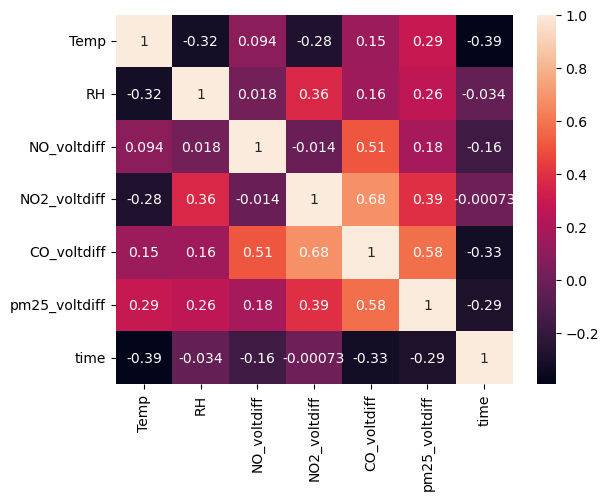

In [20]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    
    '''Create a correlation matrix to guide predictor selection '''
    variables = combined_df.drop(columns=[gname+'_voltdiff','Ref'])

    corr_matrix = variables.corr()
    sn.heatmap(corr_matrix, annot=True)
    plt.show()
    



#### ... let's simplify our correlation matrix to only consider correaltion coefficients > 0.5 which, for our purposes, we will designate as variables with potential to be collinear. Typically, a threshold of 0.7 is used but since we our considering a wide array of predictors, we will be stricter about how we approach multicollinearity

In [21]:
collinear_df = corr_matrix[ corr_matrix.iloc[:,0:len(corr_matrix)]>= 0.5 ] # identify collinear variables
collinear_df = collinear_df[ collinear_df.iloc[:,0:len(collinear_df)]!= 1 ] # remove 1 values 
collinear_df

Temp  RH  NO_voltdiff  NO2_voltdiff  CO_voltdiff  \
Temp            NaN NaN          NaN           NaN          NaN   
RH              NaN NaN          NaN           NaN          NaN   
NO_voltdiff     NaN NaN          NaN           NaN     0.505099   
NO2_voltdiff    NaN NaN          NaN           NaN     0.680823   
CO_voltdiff     NaN NaN     0.505099      0.680823          NaN   
pm25_voltdiff   NaN NaN          NaN           NaN     0.579361   
time            NaN NaN          NaN           NaN          NaN   

               pm25_voltdiff  time  
Temp                     NaN   NaN  
RH                       NaN   NaN  
NO_voltdiff              NaN   NaN  
NO2_voltdiff             NaN   NaN  
CO_voltdiff         0.579361   NaN  
pm25_voltdiff            NaN   NaN  
time                     NaN   NaN

#### from the simplified correlation matrix, we see that CO-NO2 and CO-NO are demonstrating collinearity 

##### ... we could either remove the variables as predictors or consolidate them into interaction terms, so rather than having CO and NO as seperate predictors we use CO*NO as a single predictor

##### ... since CO is demonstrating collinearity with NO and NO2 and, from our corr matrix figure, we know that NO and NO2 are not collinear, let's remove CO from our predictor pool

Working on  O3


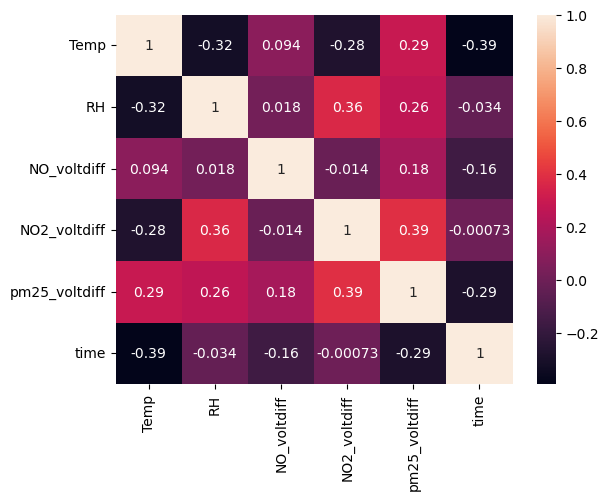

In [22]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    
    '''Remove collinear variables '''
    variables = combined_df.drop(columns=[gname+'_voltdiff','Ref','CO_voltdiff'])

    corr_matrix = variables.corr()
    sn.heatmap(corr_matrix, annot=True)
    plt.show()
    

#### Our new correlation matrix indicates no two variables are correlated with each other!

## Create scatterplots of each potential predictor vs. the uncalibrated data 

### The goal of creating the scatterplots is to further see how the sensor data are influenced by our potential predictors 

#### ... here we adapt the approach used by Zamora et al (2022) [https://doi.org/10.1021/acsestengg.1c00367]

Working on  O3


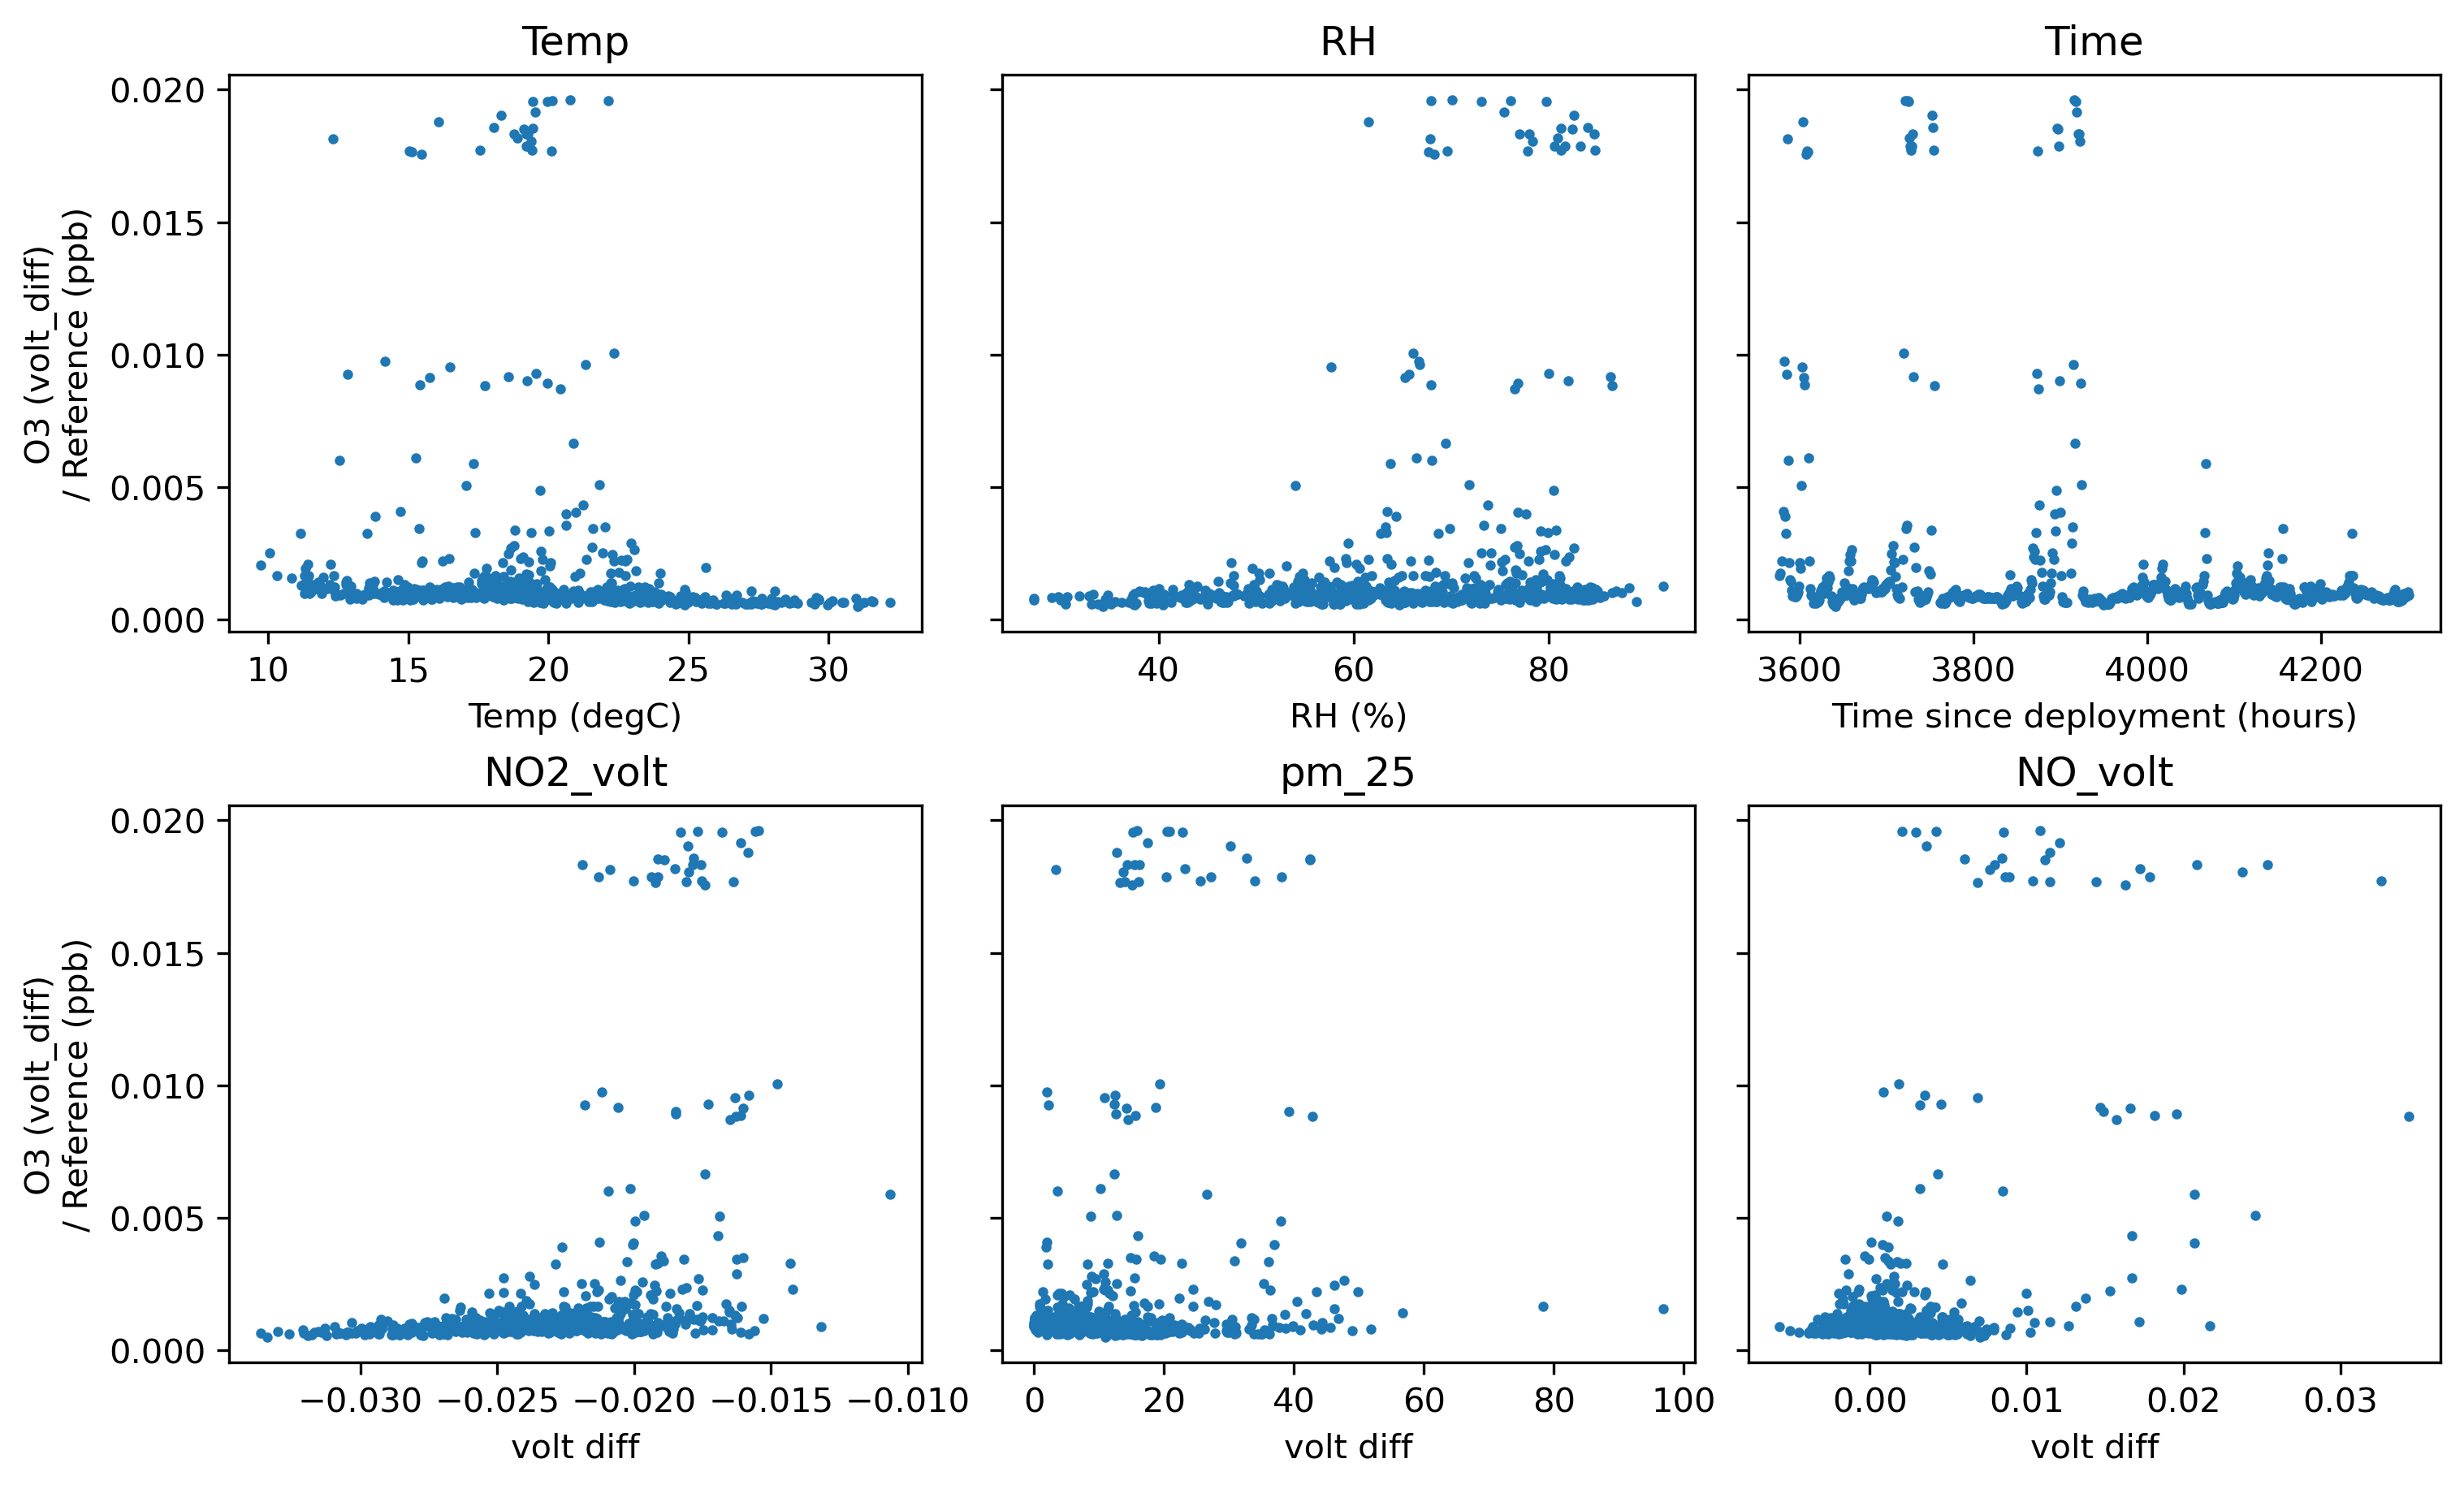

In [23]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    ''' create scatterplots '''
    variables = combined_df.drop(columns=[gname+'_voltdiff','Ref','CO_voltdiff'])
    fig, ax = plt.subplots(2, 3, sharey='row', figsize = (10,6), dpi = 300, layout='constrained')
    s = 4
    ax[0, 0].scatter(combined_df['Temp'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 0].set_title('Temp')
    ax[0, 0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
    ax[0, 0].set_xlabel('Temp (degC)')

    ax[0, 1].scatter(combined_df['RH'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 1].set_title('RH')
    ax[0, 1].set_xlabel('RH (%)')

    ax[0, 2].scatter(combined_df['time'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 2].set_title('Time')
    ax[0, 2].set_xlabel('Time since deployment (hours)')
    
    ax[1, 0].scatter(combined_df['NO2_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 0].set_title('NO2_volt')
    ax[1, 0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
    ax[1, 0].set_xlabel('volt diff')

    ax[1, 1].scatter(combined_df['pm25_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 1].set_title('pm_25')
    ax[1, 1].set_xlabel('volt diff')
    
    ax[1, 2].scatter(combined_df['NO_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 2].set_title('NO_volt')
    ax[1, 2].set_xlabel('volt diff')
    plt.show()


### From the scatterplots, we see relationships between the uncalibrated data and each variable. In Zamora et al. (2022), if a variable did not significantly influence a sensor, the scatterplot would resemble a straight line. 

##### ... we should anticipate that each of these variables may be significant predictors in a multiple linear regression model 

# Model 1: Simple MLR Model 

### Let's begin with a simple MLR model that utilizes four predictors: sensor voltage difference (equal to the concentration of the pollutant measured by the low cost sensor), temperature, relative humidity, and time 

#### For this and all models that procede, we will treat October as the calibration period for the sensor. 

##### .. we previously split October into a training and testing set using random sampling. We will train our model using the training set and evaluate it using the testing set. 

##### ... for the sake of consistency (and since I run this analysis 10000 times a day), I've stored the same randomly sampled training and testing dates in a text file stored in my local directory. 

In [24]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]
    
    # create list of predictors (note: they must be identical strings as to the column headers in the df)
    # predictors = Proto2 ozone sensor voltage difference, temperature, RH, and time since deployment 
    predictors = [gname+'_voltdiff','Temp','RH','time']
    
    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    # with our predictors loaded into a dataframe, let's create our model
    # to do this, we will use the generate_coefficients script I've written that will create a dictionary of regression coefficients
    #       for each predictor. Then, we will invoke the calibrate script I've written which uses a recursive function to 
    #       apply the regression coefficients to the input dataset
    # essentially, generate_coefficients creates the calibration model and calibrate uses the resulting regression coefficients to 
    #       calibrate testing period data
    
    # create model using generate_coefficients 
    #       generate_coefficients returns a dictionary composed of the regression coefficients ('coef_dict'), a dictionary of associated ;
    #       p-values ('pvalue_dict'), the OLS regression results created by statsmodels ('analysis'), and the actual model itself ('model')
    
    simpleModel = generate_coefficients(training_df,training_ref_conc,'linear')

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(simpleModel['coef_dict'], training_df)


Working on  O3


### We need to check that a MLR model is appropriate for our data.

#### ... to do this, we will check our model for homogeneity and plot residuals vs. fit 

Text(0.5, 1.0, 'Residuals vs. Fit')

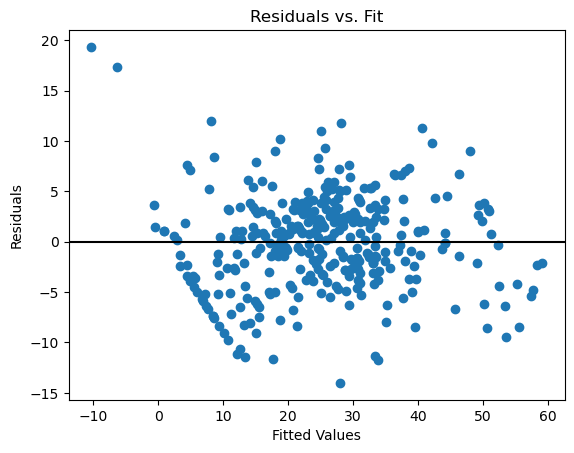

In [25]:
# access residuals 
residuals = simpleModel['model'].resid
fitted_values = training_calibrated_data

# create plot 
plt.figure()
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Residuals vs. Fit')

#### Generally, if a linear regression model is appropriate, the residuals vs. fits plot will show an equal spread. 

#### ... our residuals vs. fits plot does not demonstrate a cone shape or any distinct pattern (for the most part), so we can accept a MLR model as appropriate for our data 

### Calibrate testing period data

In [26]:
testing_calibrated_data = calibrate(simpleModel['coef_dict'], testing_df)

## Assessing model performance in October

### In low cost air quality sensor performance evaluation procedures, the quality of a calibration model is commonly determined using r-squared, slope (ref vs. calibrated data), and root mean square error 

#### ... so, let's calculate those metrics and create some plots to visualize how well our model is doing!

#### ... we will compare results between the training and testing period. To make sure we are not overfitting data, the results between the two should be fairly similar. 

In [27]:
# calculate r-squared (tells us how well our predictors explain the variation in the reference instruments observations)
from sklearn.metrics import r2_score
# for fun, I've included two ways of calculating r-squared. They return nearly identical results :p

n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
#training_r2 = r2_score(training_ref_conc,training_calibrated_data)
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2

#testing_r2 = r2_score(testing_ref_conc,testing_calibrated_data )
print('Testing period r-squared = ',testing_r2)

Training period r-squared =  0.8680211364763816
Testing period r-squared =  0.8762093930074145


#### ... the r-squared's are very similar, which is a good indication that the model is performing well. The slight increase in r-squared in the testing period does raise an alarm that the model may be capturing spikes in ozone concentrations. This is sensible because the Proto2 data we are reading in have NOT been despiked, so random fluctuations are present in the dataset. This is something that will be addressed in later work. 

In [28]:
# calculate the slope between the calibrated data and reference data, this tell us how well we are modeling the relationship between the two sensors. 
# ideally, we want a slope equal to 1. 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)


Training period slope =  0.8680211364766428
Testing period slope =  0.8923827881208825


#### ... slopes close to 1 indicate a strong relationship between our calibrated data and reference data. This means that when our calibrated predict a concentration of 10 ppb, the reference instrument will read a concentration near 10 ppb as well!

In [29]:
# calculate the root mean square error (RMSE)
# ideally, we want a RMSE near 0 

training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period RMSE =  4.7557514399190906
Testing period RMSE =  4.396177020677387


#### ... RMSE tell us about the amount of error between our predicted concentrations and the reference instrument concentrations. The closer to 0, the better the agreement. A RMSE between 4-5 for Ozone is excellent. 

### Finally, let's plot our data and visualize our calibrations 

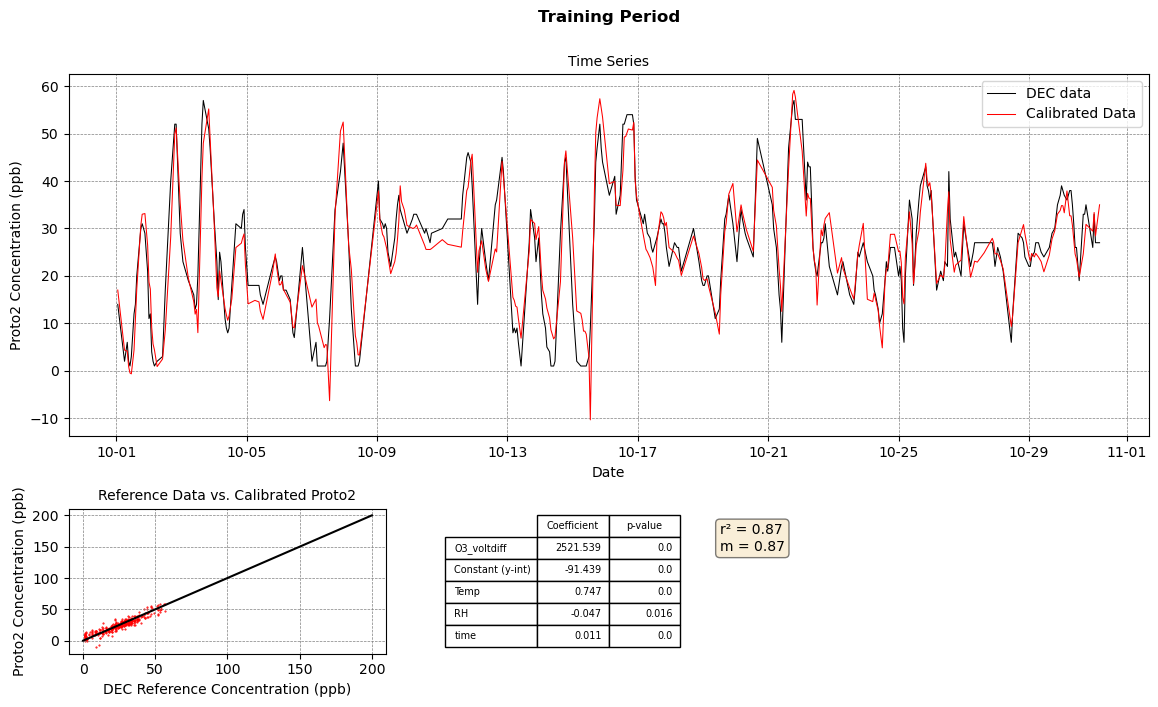

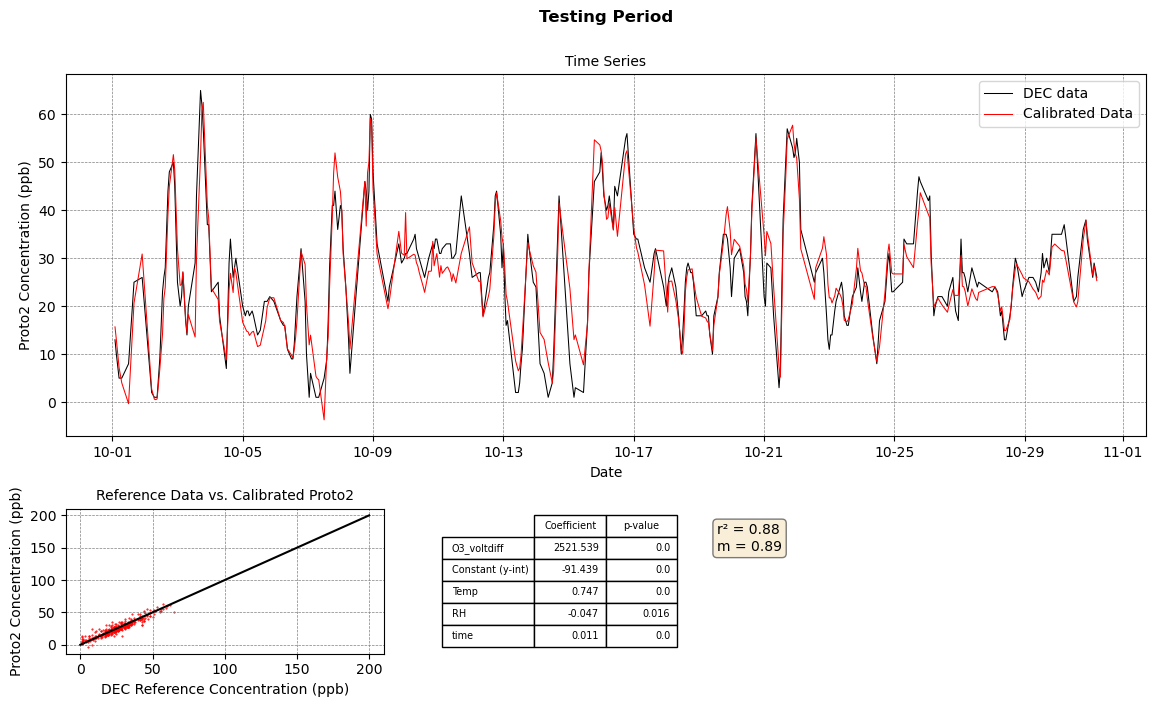

In [30]:
# plot training data first ... 
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,simpleModel['coef_dict'], simpleModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='red')

var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,simpleModel['coef_dict'], simpleModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='red')

#### With our simple MLR model passing evaluation (high r-squared, acceptable slope, and low RMSE), we will now apply the regression coefficients generated in October to data from November 2021 through April 2022 and see how the model performs over a long duration of time and variations in meteorological conditions

# Calibrate winter months

### ... Winter months = Novemeber 2021-April 2022 --> we will call this the deployment period

#### ... create simplified dataframe with with winter data 

In [31]:
DEC_wint = epa_df_matching_proto2.loc['2021-12-01 00:00:00+00:00':'2022-04-01 00:00:00+00:00']
proto2_wint = houravg.loc[DEC_wint.index]
proto2_wint_match2DEC = proto2_wint.loc[proto2_wint.index.isin(DEC_wint.index)] 

In [32]:
proto2_wint_match2DEC['O3_voltdiff']=(proto2_wint_match2DEC['O3NO2_V']-proto2_wint_match2DEC['NO2_V']).sub((proto2_wint_match2DEC['O3NO2_aux_V']-proto2_wint_match2DEC['NO2_aux_V']),axis=0)
proto2_wint_match2DEC['NO_voltdiff']=proto2_wint_match2DEC['NO_V'].sub(proto2_wint_match2DEC['NO_aux_V'],axis=0)
proto2_wint_match2DEC['NO2_voltdiff']=proto2_wint_match2DEC['NO2_V'].sub(proto2_wint_match2DEC['NO2_aux_V'],axis=0)
proto2_wint_match2DEC['CO_voltdiff']=proto2_wint_match2DEC['CO_V'].sub(proto2_wint_match2DEC['CO_aux_V'],axis=0)
proto2_wint_match2DEC['pm25_voltdiff']=proto2_wint_match2DEC['pm25_std_ugm3'].copy()
wint_df = proto2_wint_match2DEC[['temp_sht31_degC','rh_sht31_percent',
                      'O3_voltdiff','NO_voltdiff','NO2_voltdiff',
                      'CO_voltdiff','pm25_voltdiff','time']]
wint_df = wint_df.rename(columns={'temp_sht31_degC':'Temp','rh_sht31_percent':'RH'})

#### ... calibrate!

In [33]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    predictors = [gname+'_voltdiff','Temp','RH','time']
    
    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(simpleModel['coef_dict'], deployment_df)


Working on  O3


### Evaluate model performance 

In [34]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)


Deployment period r-squared =  0.6460830643773914
Deployment period slope =  0.9803108623808436
Deployment period RMSE =  13.386831173153057


#### ... it looks like our model decreased in quality during the deployment period, as signaled by the decrease in r-squared and RMSE which indicates our model struggled to explain variance during the winter months and as a result the predicted concentrations are either over or underestimated when compared to the reference instrument 

#### ... the lack of change in slope is interesting and indicates that a linear relationship between the predicted concentrations and reference concentrations is present

#### ... let's graph our calibration and see what has happened

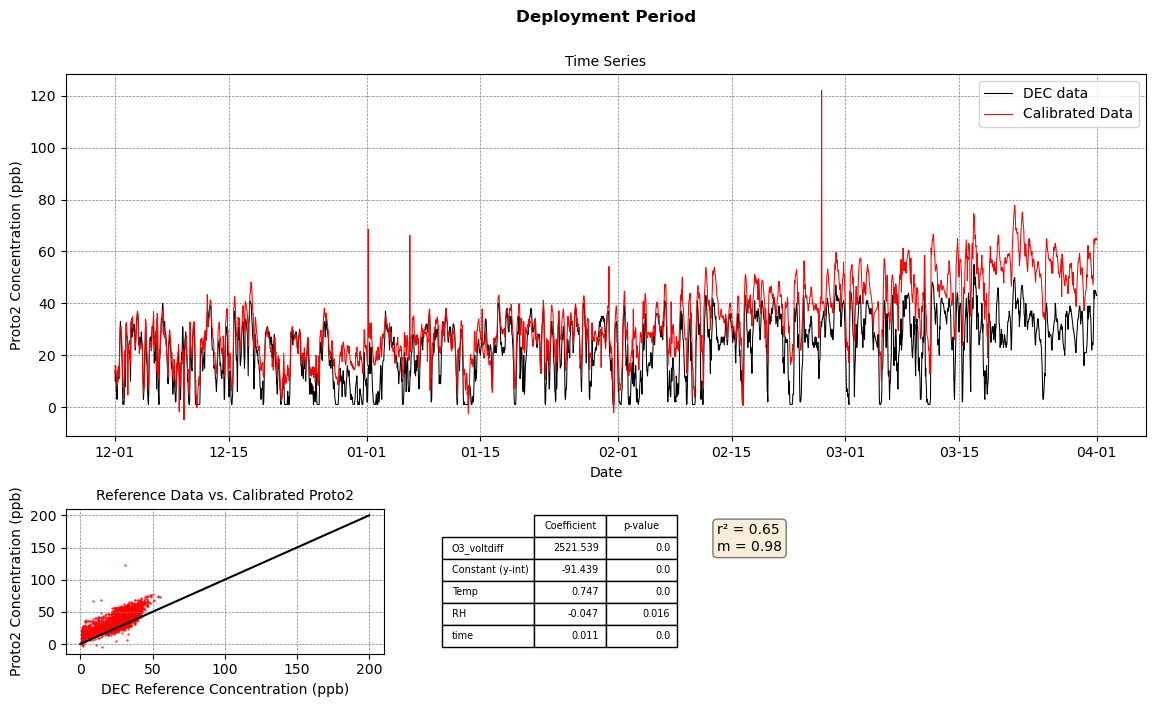

In [35]:
var_id = 44201 # O3
norm_graph(var_id,depl_calibrated_data,simpleModel['coef_dict'], simpleModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='red')

#### ... as expected the model is overestimating concentrations as time increased throughout the calibration period. When we consider the properties of ozone, this is sensible. Increasing sunlight causes an increase in ozone concentrations due to photolysis reactions, which we see happen from February to April. Our model is not capable of modeling this relationship with the current variables. 

### We should now consider ways to improve our MLR model and one approach to do so is by implementing pollutant cross-sensitivities 

#### .. from atmospheric chemistry, we know NOx is a precursor to Ozone. Thus, it is possible to improve our model by adding NO and NO2 as predictors in our model. Furthermore, pm2.5 can also be created by ozone reacting with VOCs, so we should include PM2.5 as a predictor as well. 

# Model 2: Cross-Sensitivities Model

In [36]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]
    
    # create list of predictors (note: they must be identical strings as to the column headers in the df)
    # predictors = Proto2 ozone sensor voltage difference, temperature, RH, time since deployment 
    #               NO, NO2, and pm2.5
    predictors = [gname+'_voltdiff','Temp','RH','time', 'NO_voltdiff', 'NO2_voltdiff','pm25_voltdiff']
    
    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    csModel = generate_coefficients(training_df,training_ref_conc,'linear')

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(csModel['coef_dict'], training_df)
    testing_calibrated_data = calibrate(csModel['coef_dict'], testing_df)

Working on  O3


In [37]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.943298450124757
Testing period r-squared =  0.9421571383953511
Training period slope =  0.943298450122255
Testing period slope =  0.9339221398976002
Training period RMSE =  3.117198229715823
Testing period RMSE =  3.011918693652899


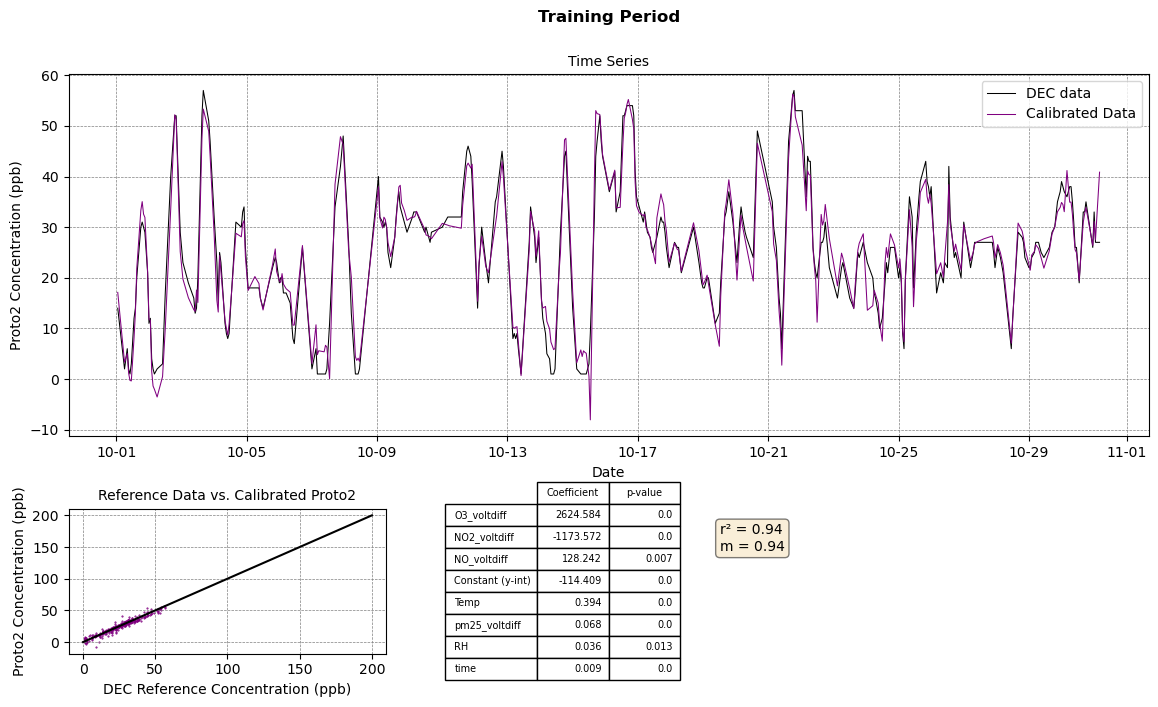

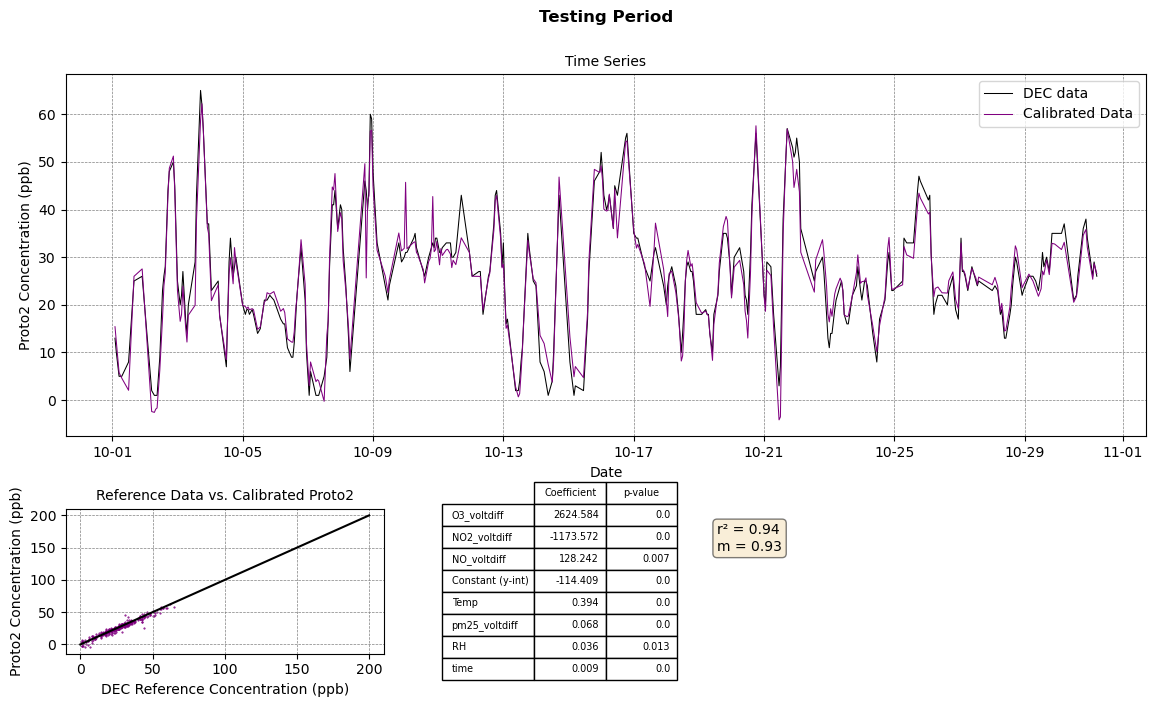

In [38]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,csModel['coef_dict'], csModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='purple')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,csModel['coef_dict'], csModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='purple')

### By adding the cross-sensitivites, our model has improved greatly! We have higher r-squareds, slopes near 1, and lower RMSE for the training and testing periods. 

#### ... now, let's do our deployment period test

In [39]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    predictors = [gname+'_voltdiff','Temp','RH','time', 'NO_voltdiff', 'NO2_voltdiff','pm25_voltdiff']
    
    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(csModel['coef_dict'], deployment_df)


Working on  O3


### Evaluate model performance 

In [40]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

Deployment period r-squared =  0.7117118883118969
Deployment period slope =  1.0198943904141493
Deployment period RMSE =  10.569196310220699


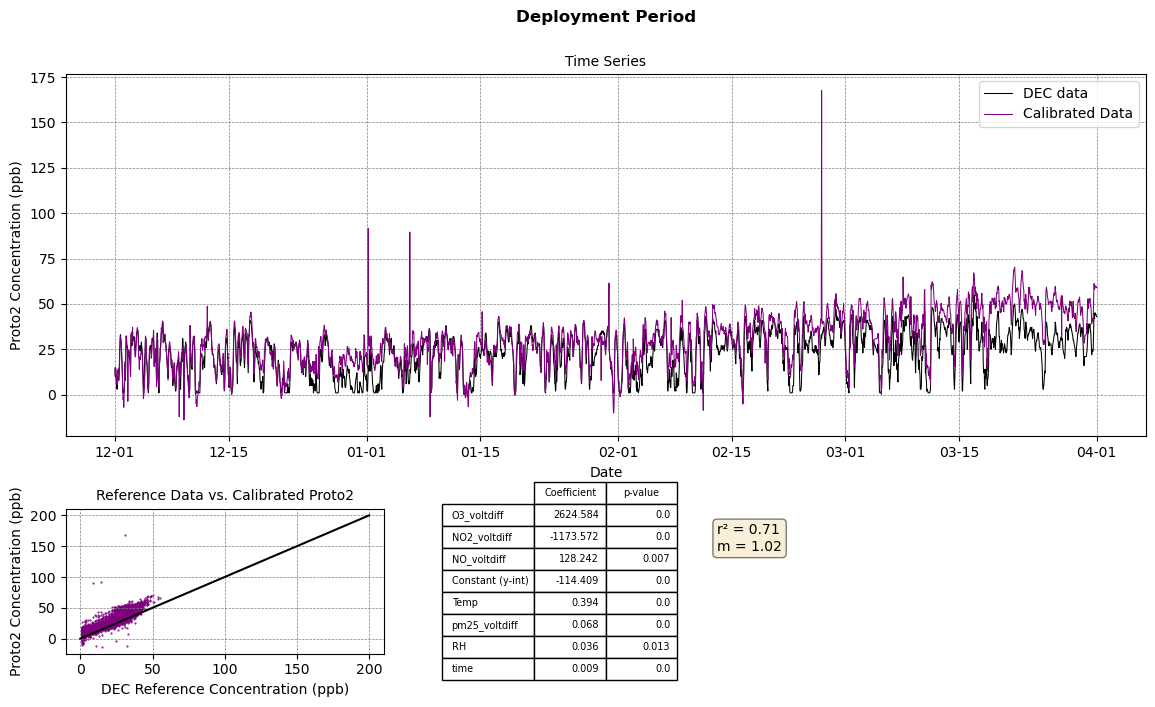

In [41]:
var_id = 44201 # O3
norm_graph(var_id,depl_calibrated_data,csModel['coef_dict'], csModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='purple')

#### ... by introducing cross-sensitivities, we've remarkably improved our model's performance when compared to our simpler model. Still, we could improve our model even more. 

### Let's create a scatterplot of our uncalibrated Ozone data vs. the reference data during the October training period 

Text(0, 0.5, 'Reference concentrations (ppb)')

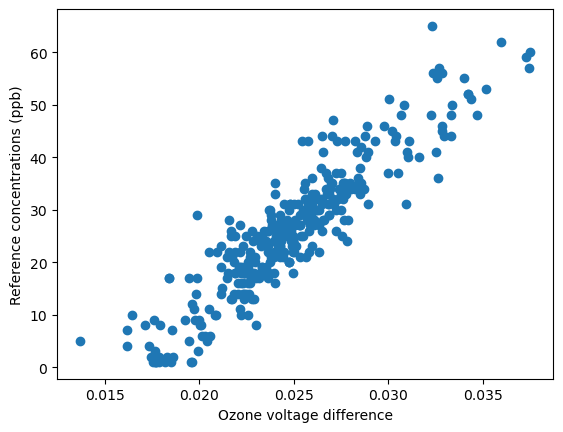

In [42]:
plt.figure()
plt.scatter(testing_df['O3_voltdiff'], testing_ref_conc)
plt.xlabel('Ozone voltage difference')
plt.ylabel('Reference concentrations (ppb)')

#### ... overall, we see a linear relationship between the Proto2 and Reference ozone measurements. However, we could split this curve into two linear lines at around x = 0.025, creating a piecewise relationship

#### ... Zamora et al. (2022) explored applying splines (also called hinge-functions) to their calibration models. In their work, they applied splines at the median temperature and relative humidity values in their training period data as well as sensor splines at the location of greatest change between the low-cost sensor and reference concentrations. Using the scatter plot above, this would be at x = 0.025

##### .... let's add a sensor spline as well as a spline at the median Temp and RH values to our simple MLR model 

# Model 3: Sensor Spline Model

In [43]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    
    # create two new coefficients = Slow and Shigh using the sensor spline
    # we will turn each coefficient on using binary variables depending on if the sensor meets the
    #       spline threshold 
    # for example, a volt diff of 0.01 would be 1 with Slow and 0 with Shigh
    sensor_spline = 0.025
    combined_df.loc[combined_df['O3_voltdiff'] <= sensor_spline, 'Slow'] = 1
    combined_df.loc[combined_df['O3_voltdiff'] > sensor_spline, 'Slow'] = 0
    combined_df.loc[combined_df['O3_voltdiff'] > sensor_spline, 'Shigh'] = 1
    combined_df.loc[combined_df['O3_voltdiff'] <= sensor_spline, 'Shigh'] = 0

    combined_df['Slow'] = combined_df['Slow']*combined_df['O3_voltdiff']
    combined_df['Shigh'] = combined_df['Slow']*combined_df['O3_voltdiff']


    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]

    predictors = ['Temp','RH','time', 'Slow', 'Shigh']
    
    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    ssplModel = generate_coefficients(training_df,training_ref_conc,'linear')

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(ssplModel['coef_dict'], training_df)
    testing_calibrated_data = calibrate(ssplModel['coef_dict'], testing_df)

Working on  O3


### Evaluate model performance

In [44]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.8105294473200676
Testing period r-squared =  0.7659988949984765
Training period slope =  0.8105294473201562
Testing period slope =  0.7803583194098188
Training period RMSE =  5.698201686000232
Testing period RMSE =  6.049560729677935


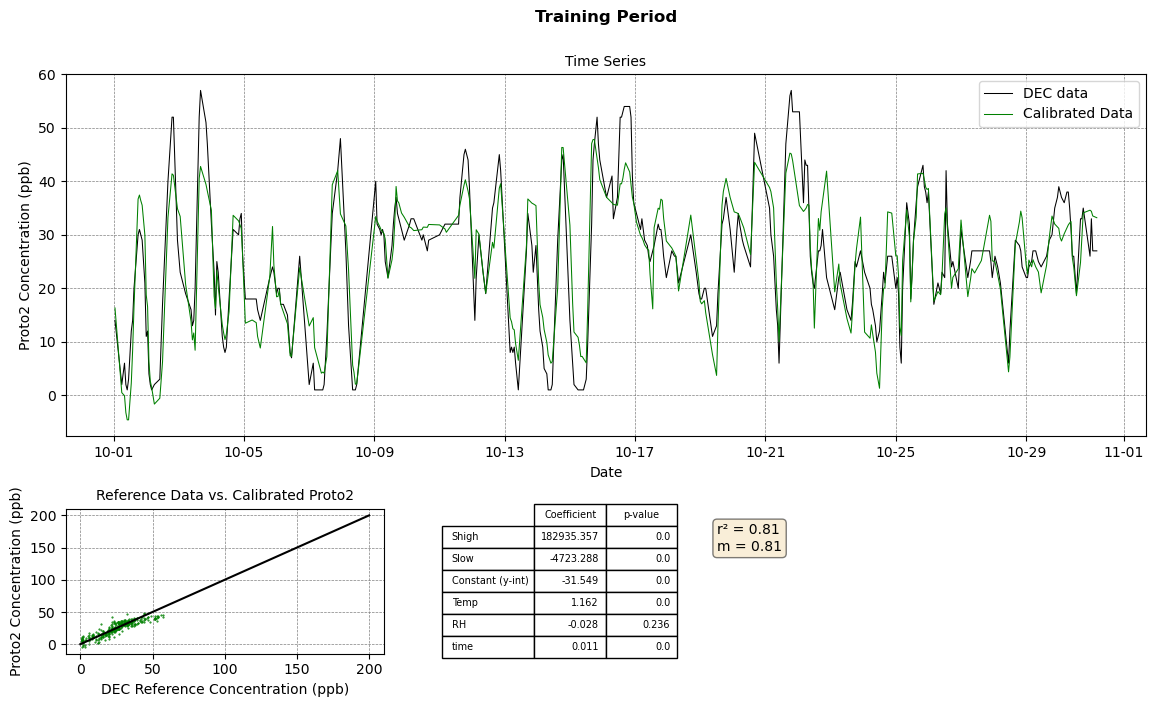

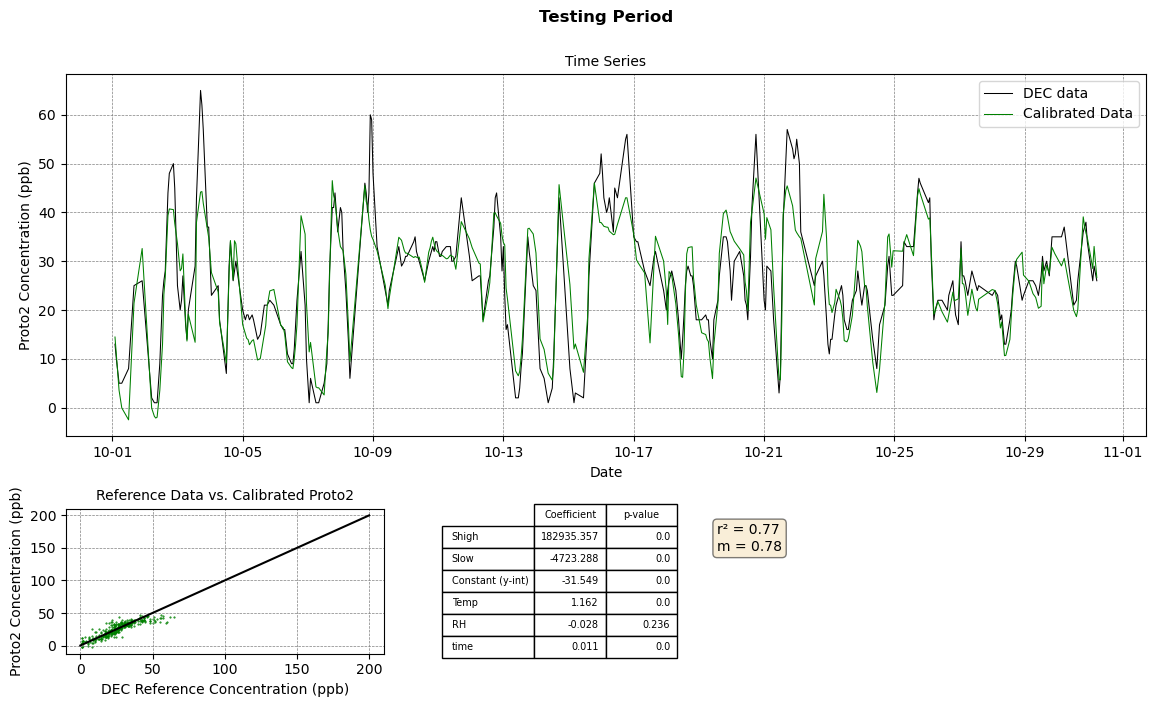

In [45]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,ssplModel['coef_dict'], ssplModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='green')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,ssplModel['coef_dict'], ssplModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='green')

### By a sensor spline, our model did little to change during the training and testing period. 

#### ... now, let's do our deployment period test

In [46]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    sensor_spline = 0.025
    deployment_df.loc[deployment_df['O3_voltdiff'] <= sensor_spline, 'Slow'] = 1
    deployment_df.loc[deployment_df['O3_voltdiff'] > sensor_spline, 'Slow'] = 0
    deployment_df.loc[deployment_df['O3_voltdiff'] > sensor_spline, 'Shigh'] = 1
    deployment_df.loc[deployment_df['O3_voltdiff'] <= sensor_spline, 'Shigh'] = 0
    deployment_df['Slow'] = deployment_df['Slow']*deployment_df['O3_voltdiff']
    deployment_df['Shigh'] = deployment_df['Slow']*deployment_df['O3_voltdiff']

    predictors = ['Temp','RH','time', 'Slow', 'Shigh']
    
    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(ssplModel['coef_dict'], deployment_df)


Working on  O3


### Evaluate model performance

In [47]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

Deployment period r-squared =  0.5351221152075635
Deployment period slope =  0.9700057889148175
Deployment period RMSE =  12.088231355013159


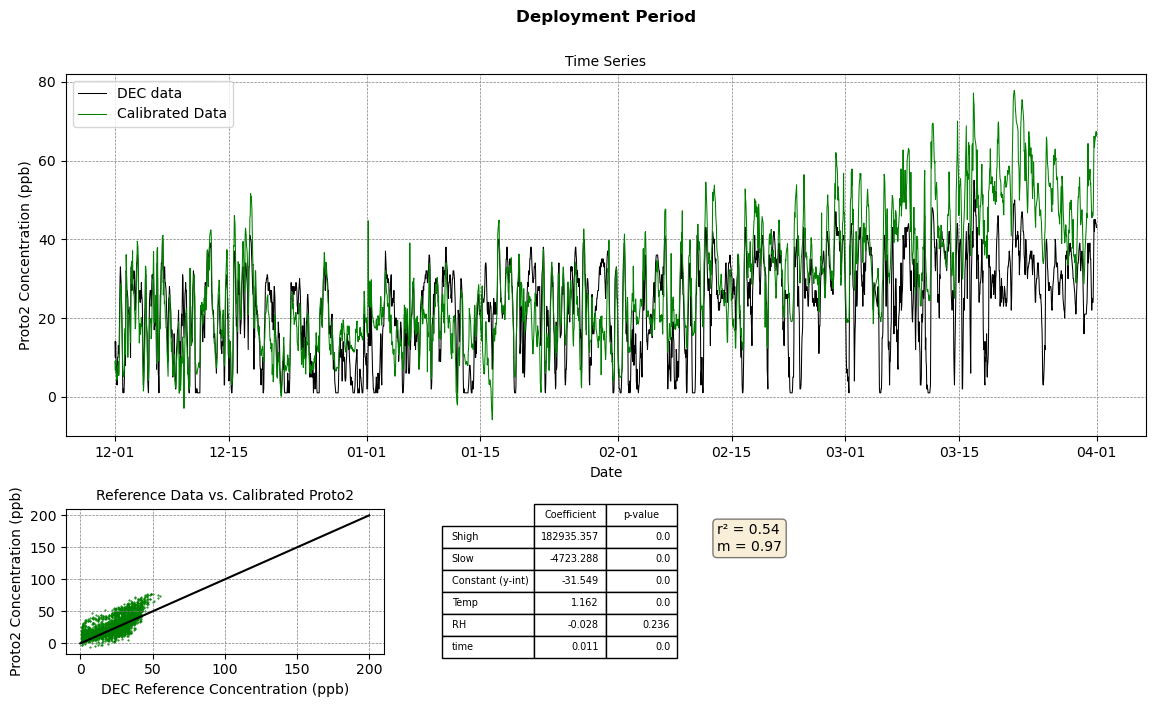

In [48]:
var_id = 44201 # O3
norm_graph(var_id,depl_calibrated_data,ssplModel['coef_dict'], ssplModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='green')

#### ... the sensor spline caused reduction in model quality, therefore we should leave it out in our final model selection.

### ... let's add splines at the median temperature and RH values and see if we find any improvements to our model 

# Model 4: Meteorological Spline Model

In [49]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)


    # adding splines for temperature and RH
    # Temp 
    oct_medianT = combined_df['Temp'].median()
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    combined_df['Tlow'] = combined_df['Tlow']*combined_df['Temp']
    combined_df['Thigh'] = combined_df['Thigh']*combined_df['Temp']

    # RH 
    oct_medianRH = combined_df['RH'].median()
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    combined_df['RHlow'] = combined_df['RHlow']*combined_df['RH']
    combined_df['RHhigh'] = combined_df['RHhigh']*combined_df['RH']

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]

    predictors = ['O3_voltdiff','time','Tlow','Thigh','RHlow','RHhigh']
    
    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    wxsplModel = generate_coefficients(training_df,training_ref_conc,'linear')

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(wxsplModel['coef_dict'], training_df)
    testing_calibrated_data = calibrate(wxsplModel['coef_dict'], testing_df)

Working on  O3


### Evaluate model performance

In [50]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.8690593050522037
Testing period r-squared =  0.8740143215893776
Training period slope =  0.8690593050520574
Testing period slope =  0.8902575517256851
Training period RMSE =  4.737009728927798
Testing period RMSE =  4.43424477163269


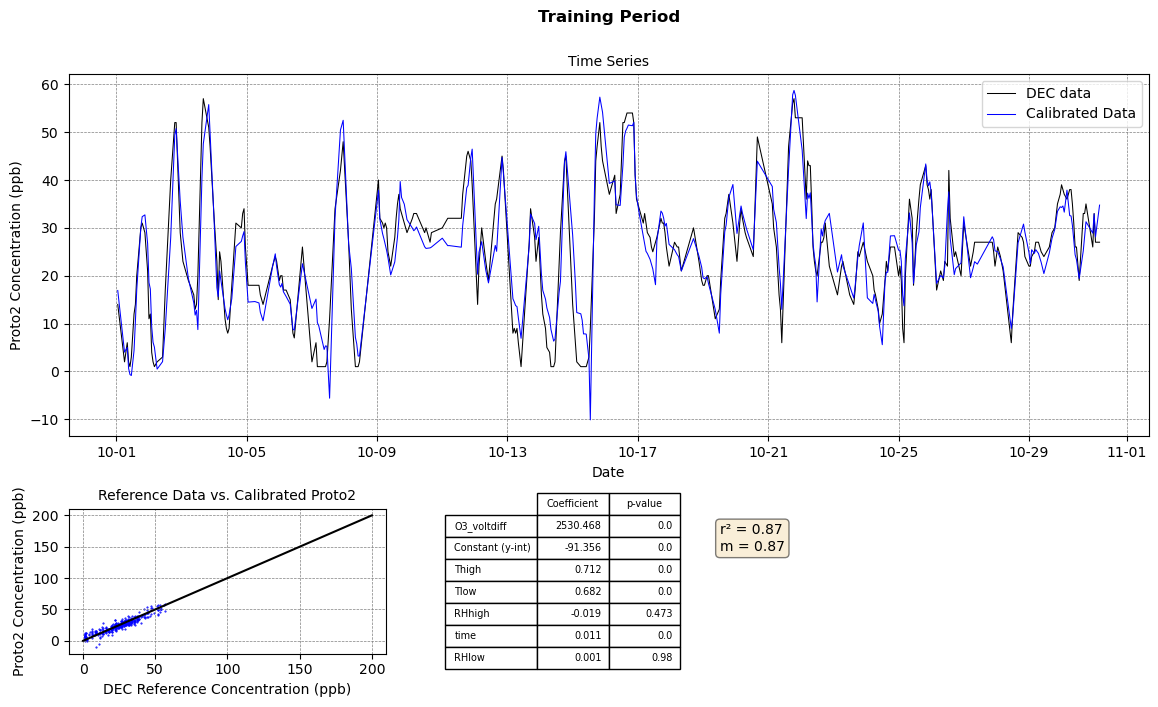

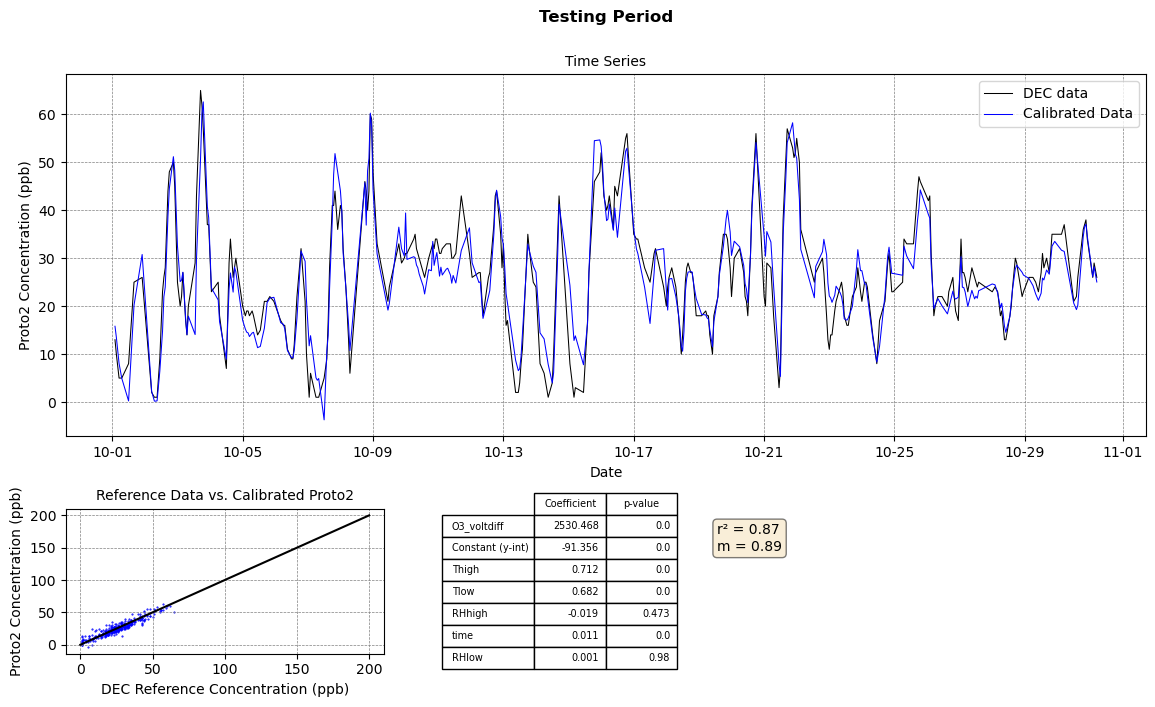

In [51]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,wxsplModel['coef_dict'], wxsplModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='blue')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,wxsplModel['coef_dict'], wxsplModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='blue')

#### ... results are consistent with our simple model for the training and testing period. Now, let's see how the model performs during the deployment period

In [52]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    # adding splines for temperature and RH
    # Temp 
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Tlow'] = 0
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Thigh'] = 1
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    deployment_df['Tlow'] = deployment_df['Tlow']*deployment_df['Temp']
    deployment_df['Thigh'] = deployment_df['Thigh']*deployment_df['Temp']

    # RH 
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHlow'] = 0
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    deployment_df['RHlow'] = deployment_df['RHlow']*deployment_df['RH']
    deployment_df['RHhigh'] = deployment_df['RHhigh']*deployment_df['RH']

    predictors = ['O3_voltdiff','time','Tlow','Thigh','RHlow','RHhigh']

    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(wxsplModel['coef_dict'], deployment_df)

Working on  O3


### Evaluate model performance

In [53]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

Deployment period r-squared =  0.65724197168371
Deployment period slope =  0.9560903332386768
Deployment period RMSE =  12.587572967378295


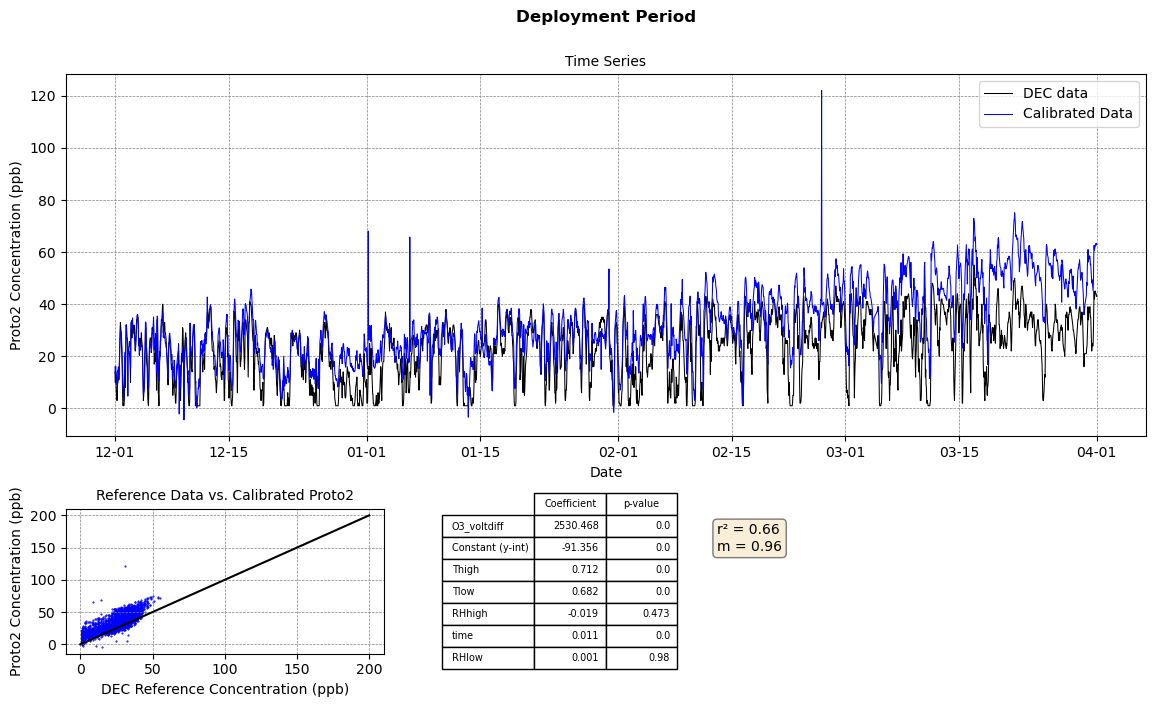

In [54]:
var_id = 44201 # O3
norm_graph(var_id,depl_calibrated_data,wxsplModel['coef_dict'], wxsplModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='blue')

### This model is *slightly* better than our simple and sensor spline model, but not nearly as impressive as our cross-sensitivity model. 

#### ... thus far, we have been producing plots that show the coefficient p-value but have largely been ignoring p-values when selecting predictors. 

#### ... let us view our predictors in a null hypothesis framework. Our null hypothesis is that the predictor does not explain the variation in our model, thus a coefficient of 0. We can reject the null hypothesis that a predictor does not explain the variation in our model if the p-value is less than 0.05. 

### Let's use the ozone voltage difference predictor as an example 

#### ...if the null hypothesis was true and ozone did NOT explain the variation in our model, there is a 0% chance of obtaining the resulting calibration by random chance alone (p = 0.0 in above plot)

#### ... however, we can accept the null hypothesis for RHLow and RHHigh because they have p-values > 0.05 and are not significant predictors in our model 

## Model 5: p-value Optimized Model

### In this model, we will combine the cross-senstivity model with the meteorological spline model. Sensor splines will not be included because we've already demonstrated the sensor spline model performed suboptimally.

In [55]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)


    # adding splines for temperature and RH
    # Temp 
    oct_medianT = combined_df['Temp'].median()
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    combined_df['Tlow'] = combined_df['Tlow']*combined_df['Temp']
    combined_df['Thigh'] = combined_df['Thigh']*combined_df['Temp']

    # RH 
    oct_medianRH = combined_df['RH'].median()
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    combined_df['RHlow'] = combined_df['RHlow']*combined_df['RH']
    combined_df['RHhigh'] = combined_df['RHhigh']*combined_df['RH']

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]

    predictors = ['O3_voltdiff','time','Tlow','Thigh','RHlow','RHhigh', 'NO_voltdiff', 'NO2_voltdiff','pm25_voltdiff']

    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    pvalModel = generate_coefficients(training_df,training_ref_conc,'linear')

    
    # in this loop, we remove the predictor with the largest p-value, re-run the model, and stop only when coefficients with
    #       p-values < 0.05 are retained 
    for i in range(len(training_df.columns)):
        del pvalModel['pvalue_dict']['Y-intercept (constant term)']
        highest_pval_pred = max(pvalModel['pvalue_dict'], key=pvalModel['pvalue_dict'].get)

        if pvalModel['pvalue_dict'][highest_pval_pred] > 0.05:
            training_df = training_df.drop(highest_pval_pred, axis=1)
            testing_df = testing_df.drop(highest_pval_pred, axis=1)
            coefficients = generate_coefficients(training_df,training_ref_conc,'linear')
            print('Removed ...',highest_pval_pred)

        else:
            training_calibrated_data = calibrate(pvalModel['coef_dict'], testing_df)
            print('Done')
            break
    

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(pvalModel['coef_dict'], training_df)
    testing_calibrated_data = calibrate(pvalModel['coef_dict'], testing_df)

Working on  O3
Done


#### ... you'll notice that no predictors were removed. It is likely that the inclusion of cross-senstivities resulted in T and RH needing to be retained in the final model 

### Evaluate model performance

In [56]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.9462037567379229
Testing period r-squared =  0.9434043020458499
Training period slope =  0.9462037567367784
Testing period slope =  0.9309659925223231
Training period RMSE =  3.036287770206683
Testing period RMSE =  2.978155405262362


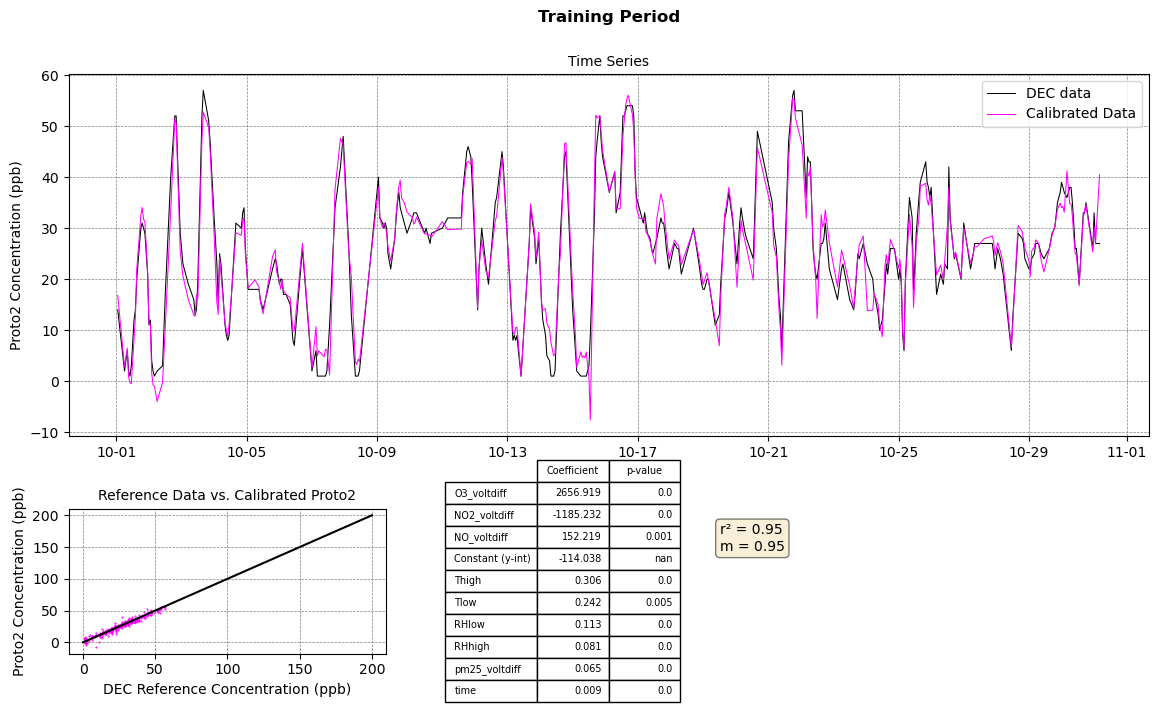

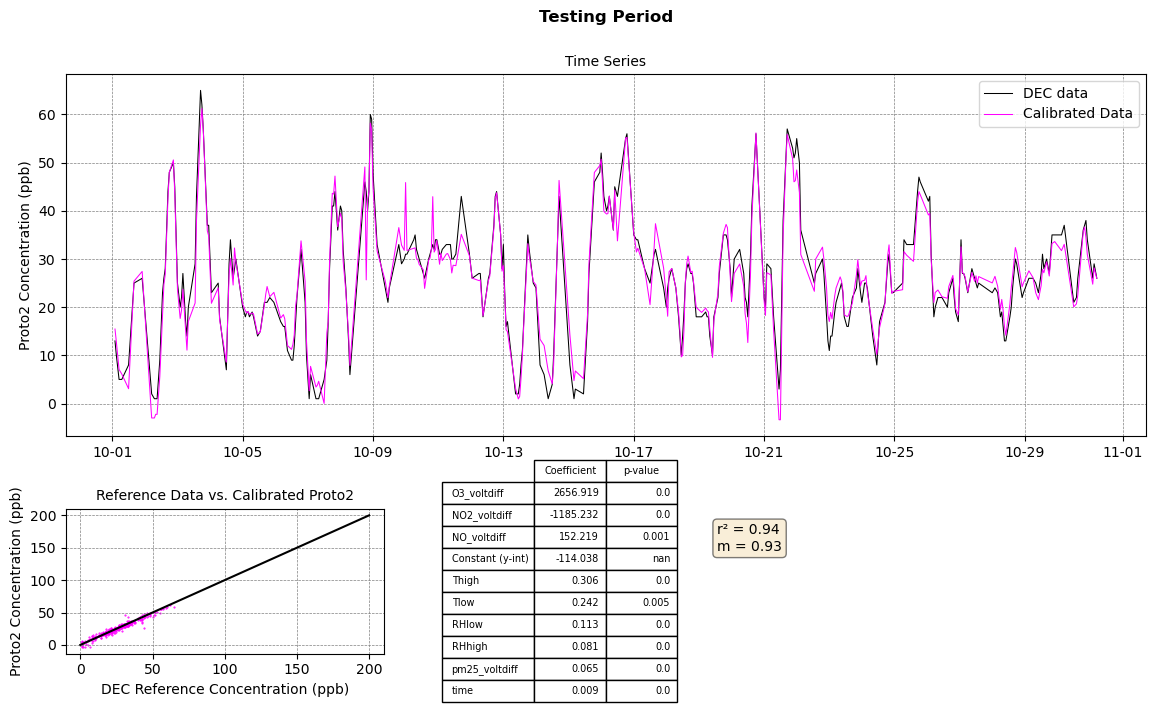

In [57]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,pvalModel['coef_dict'], pvalModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='magenta')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,pvalModel['coef_dict'], pvalModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='magenta')

### Let's assess the deployment period 

In [58]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    # adding splines for temperature and RH
    # Temp 
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Tlow'] = 0
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Thigh'] = 1
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    deployment_df['Tlow'] = deployment_df['Tlow']*deployment_df['Temp']
    deployment_df['Thigh'] = deployment_df['Thigh']*deployment_df['Temp']

    # RH 
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHlow'] = 0
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    deployment_df['RHlow'] = deployment_df['RHlow']*deployment_df['RH']
    deployment_df['RHhigh'] = deployment_df['RHhigh']*deployment_df['RH']

    predictors = ['O3_voltdiff','time','Tlow','Thigh','RHlow','RHhigh','NO_voltdiff', 'NO2_voltdiff','pm25_voltdiff']


    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(pvalModel['coef_dict'], deployment_df)

Working on  O3


### Evaluate model performance

In [59]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

Deployment period r-squared =  0.7275483364839949
Deployment period slope =  0.9790748502430052
Deployment period RMSE =  9.499700774430737


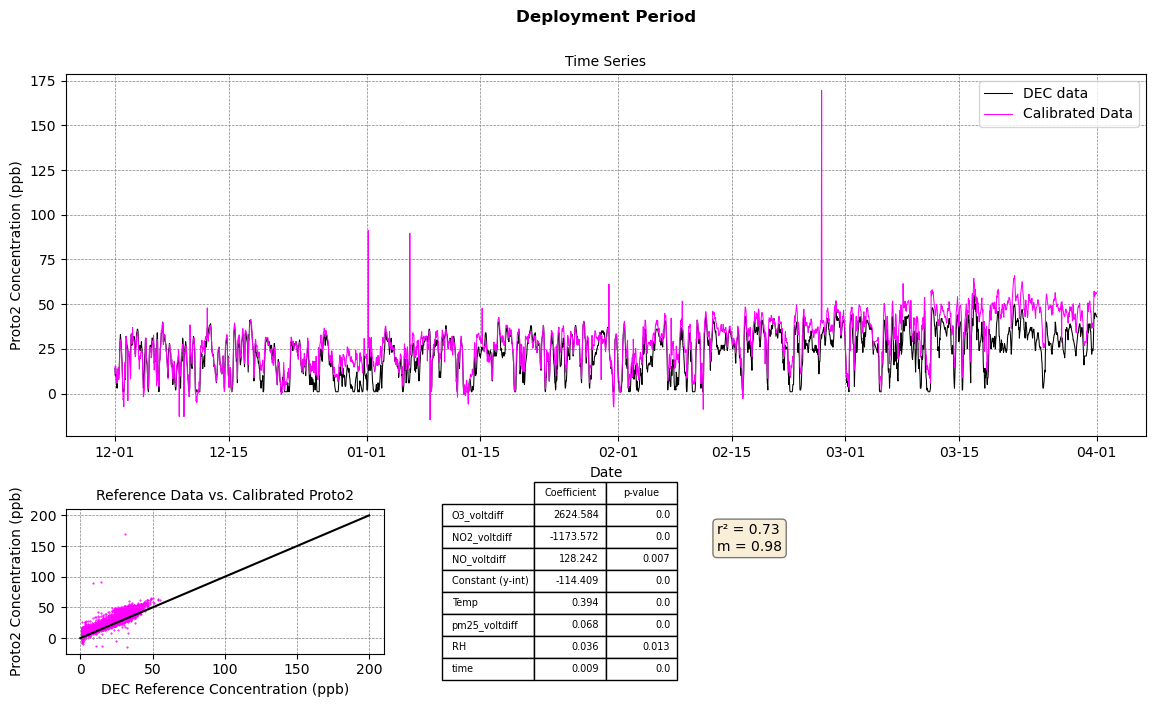

In [60]:
var_id = 44201 # O3
norm_graph(var_id,depl_calibrated_data,csModel['coef_dict'], csModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='magenta')

#### ... of the five models we have made, this model has the high r-squared and lowest RMSE but it is not a remarkable improvement when compared to our cross-sensitivity model 

#### ... let's use the Bayesian Information Criterion (BIC) to pick which model is best for our purposes. The BIC assess the goodness of fit of a model while also penalizing for the number of predictors used 

### BIC Selection

#### ... we want the model with the lowest BIC score 

In [61]:
simpleModel['model'].bic

2078.2689630794857

In [62]:
pvalModel['model'].bic

1798.7534484348448

In [63]:
csModel['model'].bic

1805.165845517928

#### ... while they don't differ by much, the pval optimization model has the lowest BIC score. Coupled with its slightly better performance, it is the most ideal model of the 5 we have created!

# Let's replicate this analysis for another pollutant, CO

### Why CO? Generally, CO calibration models are simple, containing minimal predictors. If our pvalue optimization is working as intended, very few predictors will be retained in our final CO model

### Preliminary work ... check for multicollinearity and ensure linear regression is applicable

Working on  CO


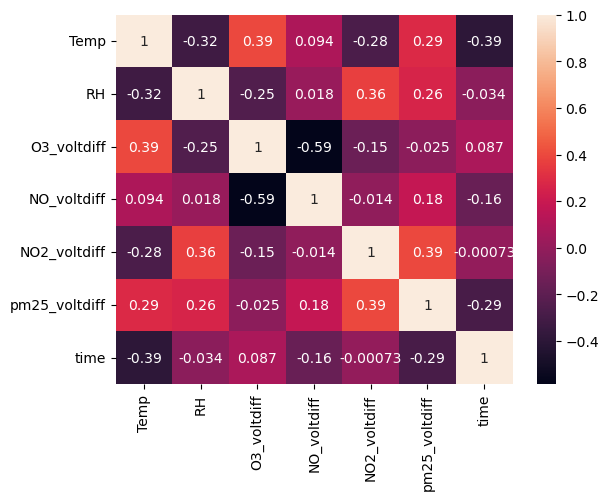

In [64]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    
    '''Create a correlation matrix to guide predictor selection '''
    variables = combined_df.drop(columns=[gname+'_voltdiff','Ref'])

    corr_matrix = variables.corr()
    sn.heatmap(corr_matrix, annot=True)
    plt.show()
    


#### ... remove consolidate NO and O3 into one term 

Working on  CO


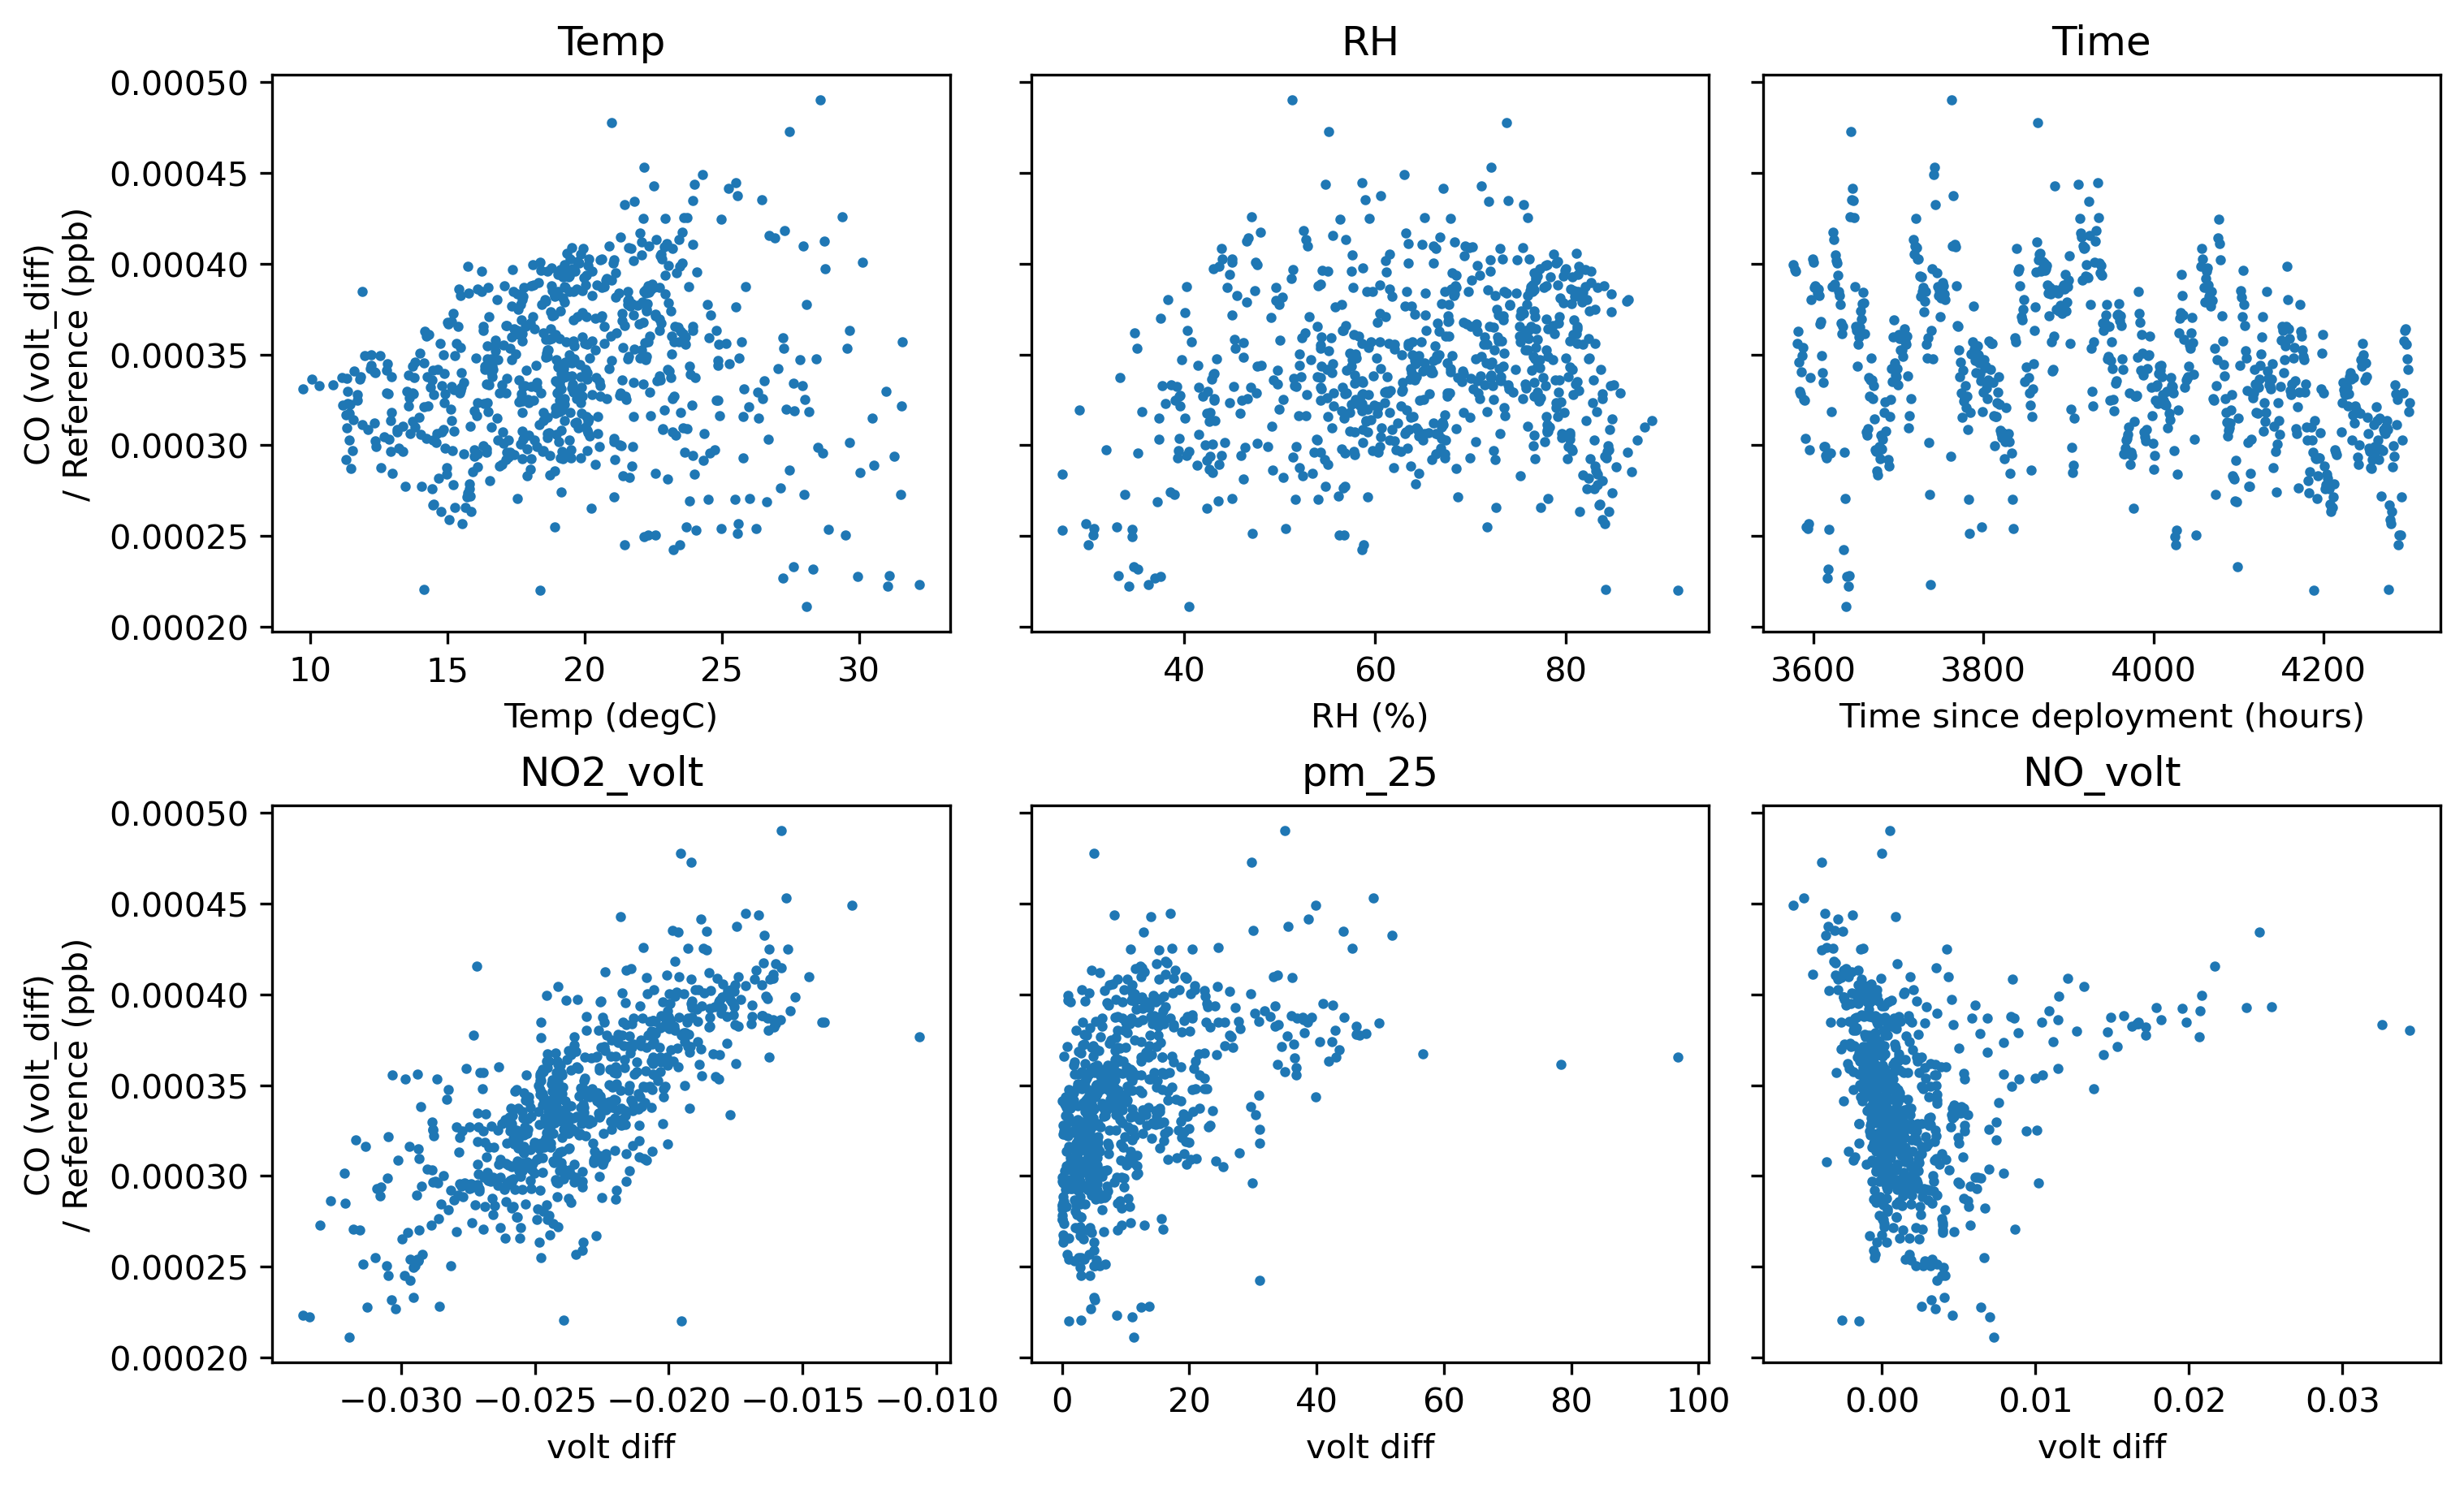

In [65]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    ''' create scatterplots '''
    variables['NO*O3'] = variables['O3_voltdiff']*variables['NO_voltdiff']

    fig, ax = plt.subplots(2, 3, sharey='row', figsize = (10,6), dpi = 300, layout='constrained')
    s = 4
    ax[0, 0].scatter(combined_df['Temp'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 0].set_title('Temp')
    ax[0, 0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
    ax[0, 0].set_xlabel('Temp (degC)')

    ax[0, 1].scatter(combined_df['RH'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 1].set_title('RH')
    ax[0, 1].set_xlabel('RH (%)')

    ax[0, 2].scatter(combined_df['time'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[0, 2].set_title('Time')
    ax[0, 2].set_xlabel('Time since deployment (hours)')
    
    ax[1, 0].scatter(combined_df['NO2_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 0].set_title('NO2_volt')
    ax[1, 0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
    ax[1, 0].set_xlabel('volt diff')

    ax[1, 1].scatter(combined_df['pm25_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 1].set_title('pm_25')
    ax[1, 1].set_xlabel('volt diff')
    
    ax[1, 2].scatter(combined_df['NO_voltdiff'],(combined_df[gname+'_voltdiff']/combined_df['Ref']),s=s),
    ax[1, 2].set_title('NO_volt')
    ax[1, 2].set_xlabel('volt diff')
    plt.show()

In [81]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)


    # adding splines for temperature and RH
    # Temp 
    oct_medianT = combined_df['Temp'].median()
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['Temp'] > oct_medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    combined_df['Tlow'] = combined_df['Tlow']*combined_df['Temp']
    combined_df['Thigh'] = combined_df['Thigh']*combined_df['Temp']

    # RH 
    oct_medianRH = combined_df['RH'].median()
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    combined_df['RHlow'] = combined_df['RHlow']*combined_df['RH']
    combined_df['RHhigh'] = combined_df['RHhigh']*combined_df['RH']

    combined_df['O3*NO'] = combined_df['NO_voltdiff']*combined_df['O3_voltdiff']

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]

    predictors = ['CO_voltdiff','time','Tlow','Thigh','RHlow','RHhigh', 'NO2_voltdiff','pm25_voltdiff','O3*NO']

    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]

    
    # in this loop, we remove the predictor with the largest p-value, re-run the model, and stop only when coefficients with
    #       p-values < 0.05 are retained 
    for i in range(len(training_df.columns)):
        CO_Model = generate_coefficients(training_df,training_ref_conc,'linear')
        del CO_Model['pvalue_dict']['Y-intercept (constant term)']
        highest_pval_pred = max(CO_Model['pvalue_dict'], key=CO_Model['pvalue_dict'].get)

        if pvalModel['pvalue_dict'][highest_pval_pred] >= 0.05:
            training_df = training_df.drop(highest_pval_pred, axis=1)
            testing_df = testing_df.drop(highest_pval_pred, axis=1)
            coefficients = generate_coefficients(training_df,training_ref_conc,'linear')
            print('Removed ...',highest_pval_pred)

        else:
            #training_calibrated_data = calibrate(CO_Model['coef_dict'], testing_df)
            print('Done')
            break
    

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(CO_Model['coef_dict'], training_df)
    testing_calibrated_data = calibrate(CO_Model['coef_dict'], testing_df)

Working on  CO
Done


### Evaluate model performance

In [82]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.9764545438455178
Testing period r-squared =  0.9813573464823898
Training period slope =  0.9764545438457967
Testing period slope =  0.97599350478087
Training period RMSE =  16.379126974637188
Testing period RMSE =  13.695832211895633


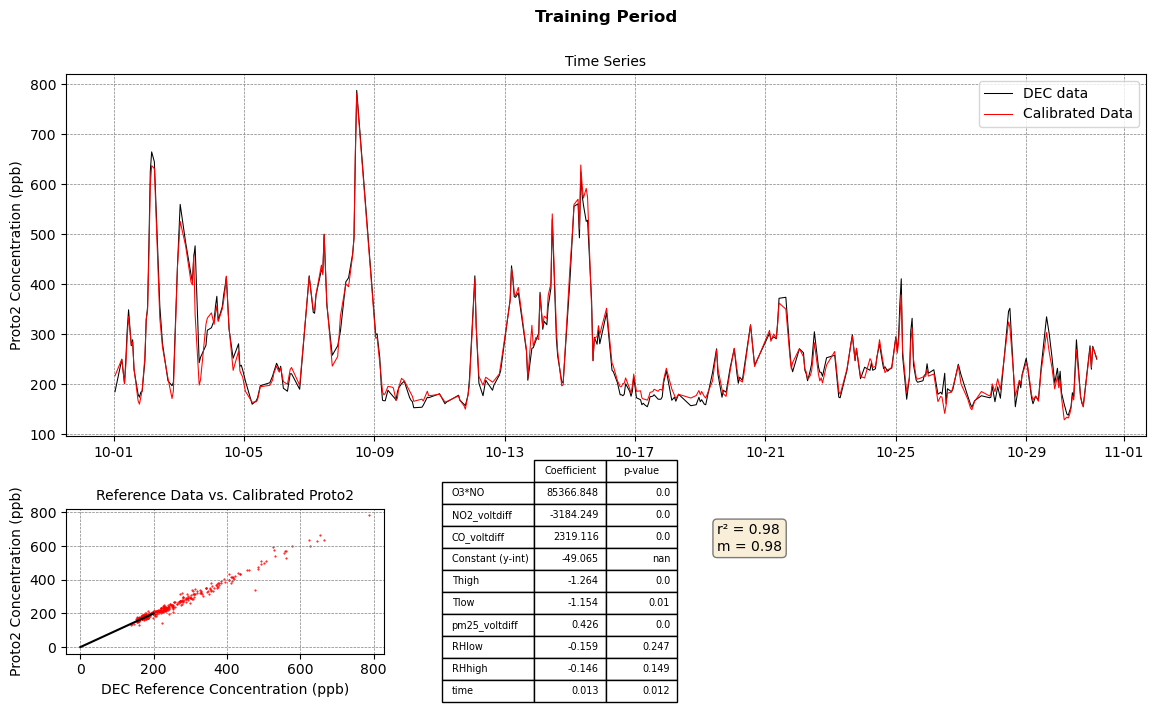

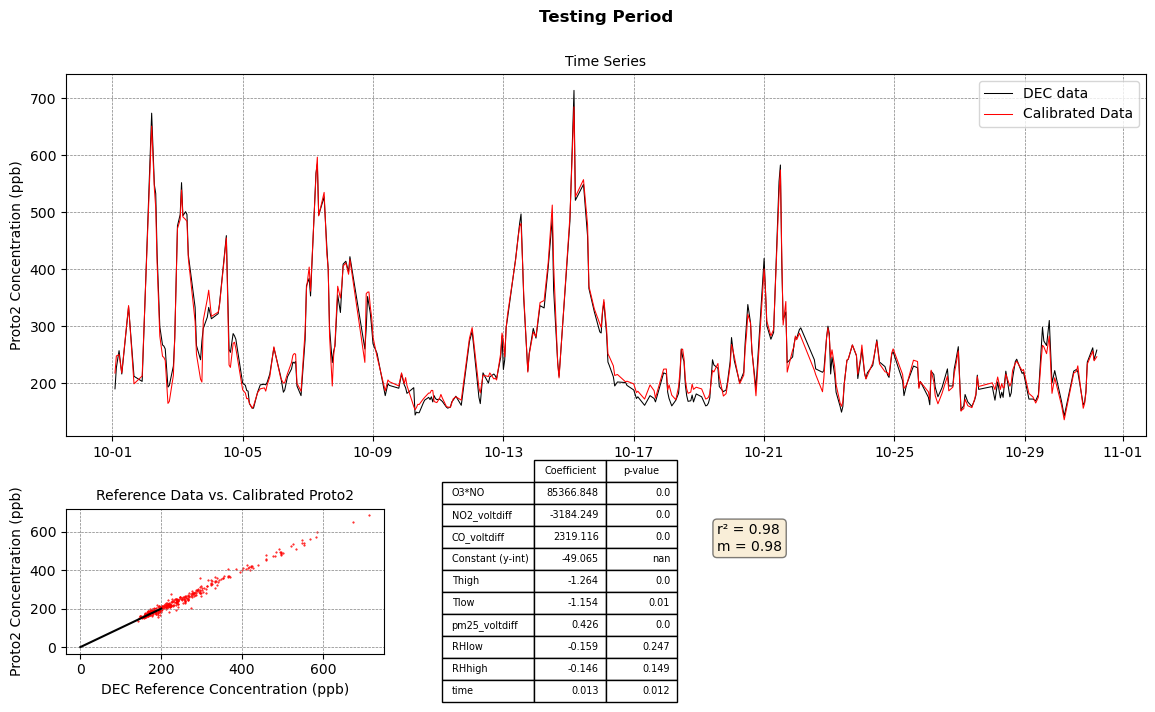

In [83]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 44201 # O3
norm_graph(var_id,training_calibrated_data,CO_Model['coef_dict'], CO_Model['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='red')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,CO_Model['coef_dict'], CO_Model['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='red')

## Deployment period results

In [84]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)
    # adding splines for temperature and RH
    # Temp 
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Tlow'] = 1
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Tlow'] = 0
    deployment_df.loc[deployment_df['Temp'] > oct_medianT, 'Thigh'] = 1
    deployment_df.loc[deployment_df['Temp'] <= oct_medianT, 'Thigh'] = 0
    deployment_df['Tlow'] = deployment_df['Tlow']*deployment_df['Temp']
    deployment_df['Thigh'] = deployment_df['Thigh']*deployment_df['Temp']

    # RH 
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHlow'] = 1
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHlow'] = 0
    deployment_df.loc[deployment_df['RH'] > oct_medianRH, 'RHhigh'] = 1
    deployment_df.loc[deployment_df['RH'] <= oct_medianRH, 'RHhigh'] = 0
    deployment_df['RHlow'] = deployment_df['RHlow']*deployment_df['RH']
    deployment_df['RHhigh'] = deployment_df['RHhigh']*deployment_df['RH']

    deployment_df['O3*NO'] = deployment_df['NO_voltdiff']*deployment_df['O3_voltdiff']

    predictors = ['CO_voltdiff','time','Tlow','Thigh','RHlow','RHhigh', 'NO2_voltdiff','pm25_voltdiff','O3*NO']

    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(CO_Model['coef_dict'], deployment_df)

Working on  CO


### Evaluate model performance

In [85]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

Deployment period r-squared =  0.9378588106153459
Deployment period slope =  0.6982961193193751
Deployment period RMSE =  61.23097447311305


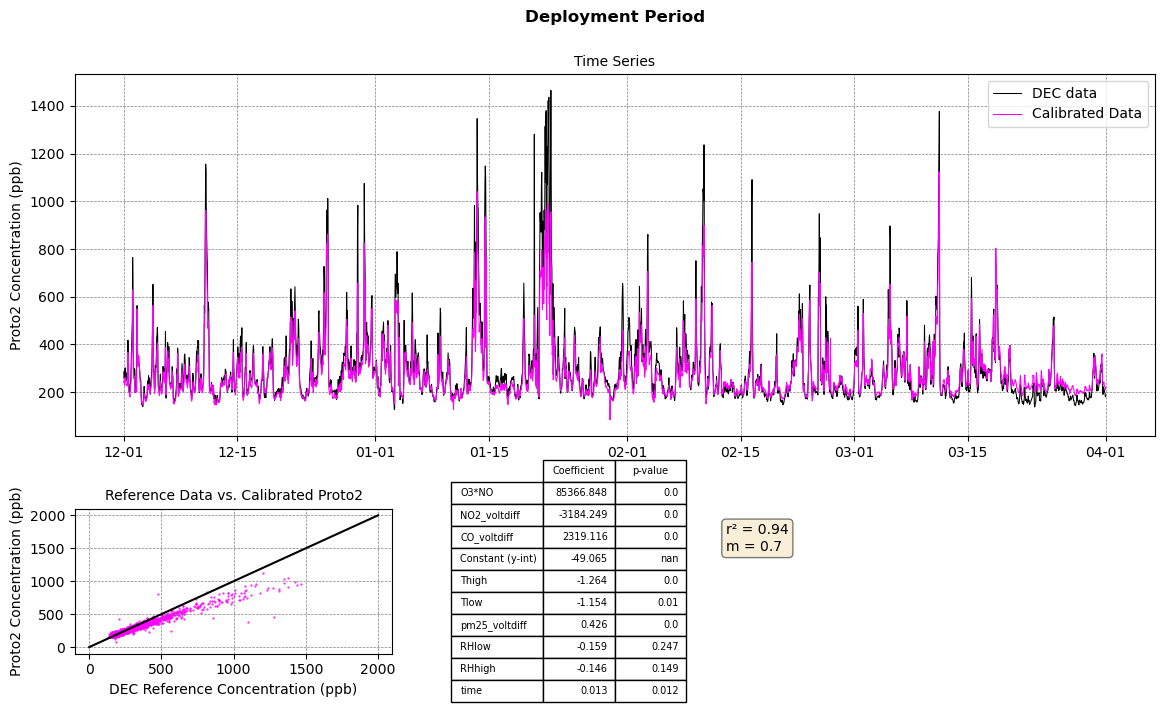

In [86]:
var_id = 42101 # O3
norm_graph(var_id,depl_calibrated_data,CO_Model['coef_dict'], CO_Model['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='magenta')

### for comparison purposes, let's create a simple model for CO 

In [87]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('Ref')
    combined_df=pd.concat([epa_concentration_field,df],axis=1).dropna()

    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    # delineate training and testing periods
    training_df=combined_df.loc[training_dates['date']] 
    testing_df=combined_df.loc[testing_dates['date']]
    
    # create list of predictors (note: they must be identical strings as to the column headers in the df)
    # predictors = Proto2 ozone sensor voltage difference, temperature, RH, and time since deployment 
    predictors = [gname+'_voltdiff','Temp','RH','time']
    
    # create variables for our reference concentrations 
    training_ref_conc = training_df['Ref']
    testing_ref_conc = testing_df['Ref']


    # create dataframes composed of just the training and testing period predictor data 
    training_df = training_df[predictors]    
    testing_df = testing_df[predictors]
    
    simpleCOModel = generate_coefficients(training_df,training_ref_conc,'linear')

    # access regression coefficients and apply to our training period data 
    training_calibrated_data = calibrate(simpleCOModel['coef_dict'], training_df)
    testing_calibrated_data = calibrate(simpleCOModel['coef_dict'], testing_df)

Working on  CO


In [88]:
# R-SQUARED
n=len(training_ref_conc)
training_r2 = (((n*(training_calibrated_data*training_ref_conc).sum())-(training_calibrated_data.sum()*training_ref_conc.sum()))\
        /np.sqrt((n*(training_ref_conc**2).sum()-(training_ref_conc).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
print('Training period r-squared = ',training_r2)

n=len(testing_ref_conc)
testing_r2 = (((n*(testing_calibrated_data*testing_ref_conc).sum())-(testing_calibrated_data.sum()*testing_ref_conc.sum()))\
        /np.sqrt((n*(testing_ref_conc**2).sum()-(testing_ref_conc).sum()**2)*\
                 (n*(testing_calibrated_data**2).sum()-testing_calibrated_data.sum()**2)))**2
print('Testing period r-squared = ',testing_r2)

# SLOPE 

training_slope = np.polyfit(training_ref_conc,training_calibrated_data,1)[0]
print('Training period slope = ',training_slope)

testing_slope = np.polyfit(testing_ref_conc,testing_calibrated_data,1)[0]
print('Testing period slope = ',testing_slope)

# RMSE
training_rmse = mean_squared_error(training_ref_conc, training_calibrated_data, squared=False)
print('Training period RMSE = ',training_rmse)

testing_rmse = mean_squared_error(testing_ref_conc, testing_calibrated_data, squared=False)
print('Testing period RMSE = ',testing_rmse)

Training period r-squared =  0.9622895570700263
Testing period r-squared =  0.9588151279358755
Training period slope =  0.962289557069671
Testing period slope =  0.9740911113090779
Training period RMSE =  20.728506501491736
Testing period RMSE =  20.437553502908386


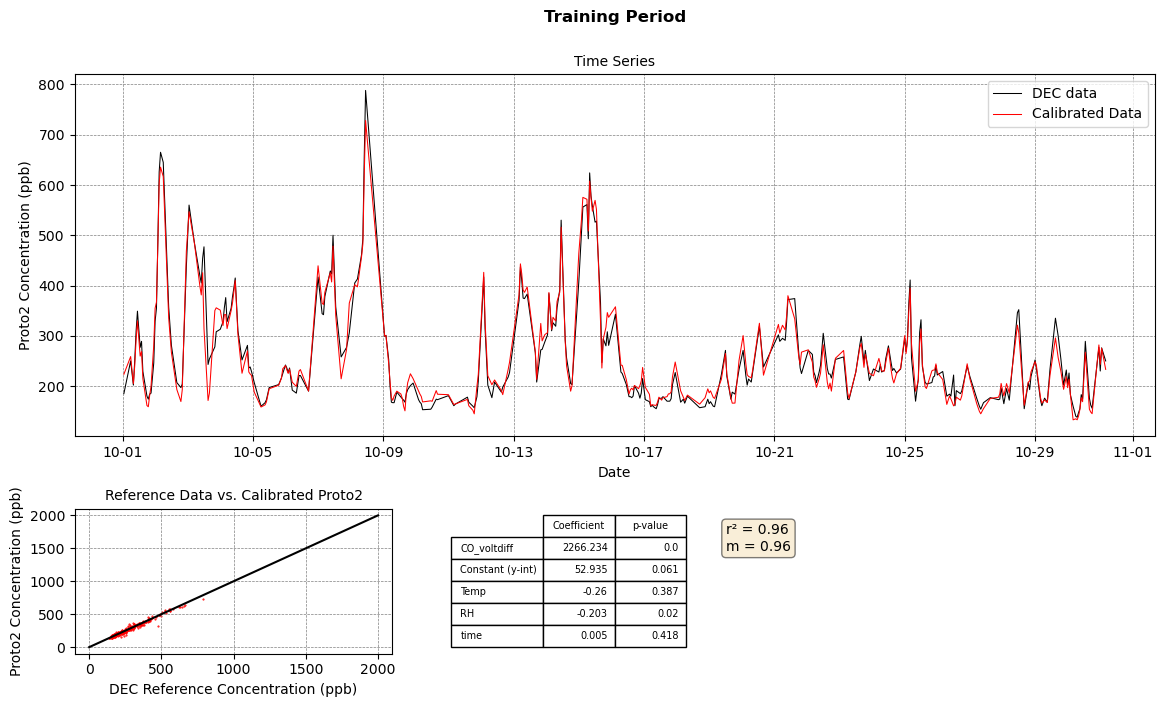

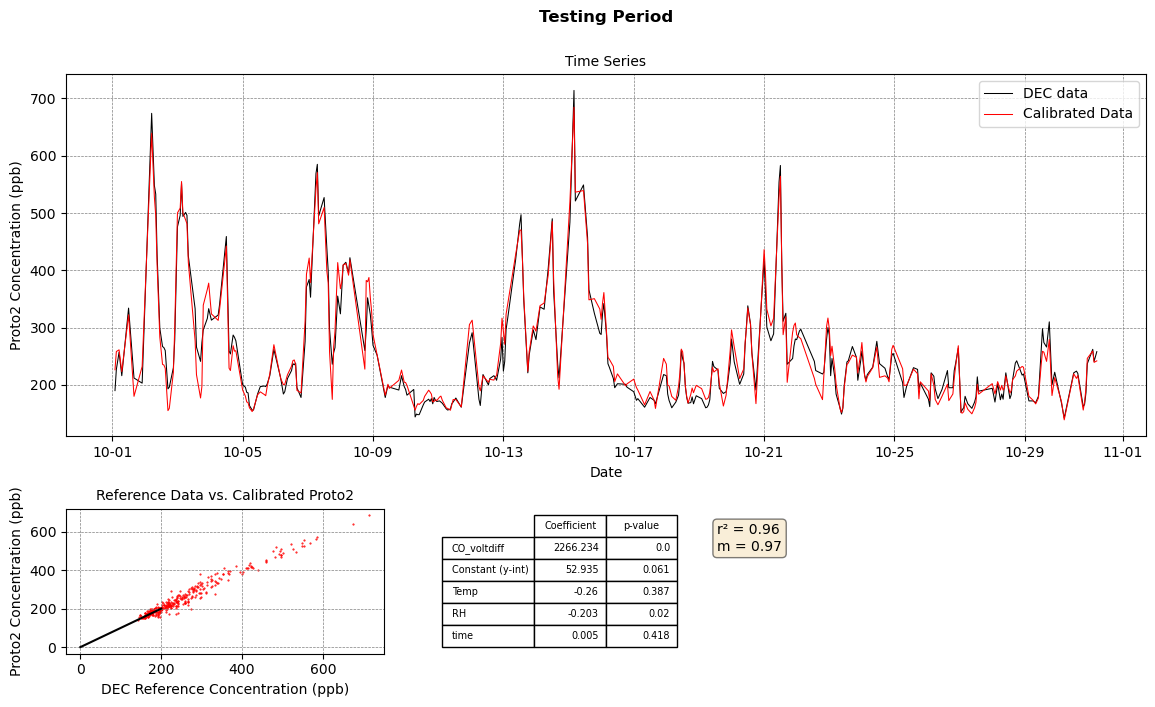

In [89]:
# norm_graph is a function that will generate analysis plots of calibration results 

var_id = 42101 # CO
norm_graph(var_id,training_calibrated_data,simpleCOModel['coef_dict'], simpleCOModel['pvalue_dict'],
           training_ref_conc, training_ref_conc.index,'Training Period', linear_color='red')

# plot testing data
var_id = 44201 # O3
norm_graph(var_id,testing_calibrated_data,simpleCOModel['coef_dict'], simpleCOModel['pvalue_dict'],
           testing_ref_conc, testing_ref_conc.index,'Testing Period', linear_color='red')

In [90]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

    fname=proto2_table[str(var_id)]
    gname_loc=fname.find('ppb')-1
    gname=fname[:gname_loc]
    
    # adding reference data to dataframe 
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('Ref')
    #combine the observations and proto2 data into one dataset
    deployment_df=pd.concat([epa_concentration_field,wint_df],axis=1).dropna()
    
    if var_id==88101:
        pltunit = 'ug/m³'
        gname = 'pm25'
    else:
        pltunit = 'ppb'
        if var_id == 44201:
            gname = 'O3'
        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

    print('Working on ', gname)

    predictors = [gname+'_voltdiff','Temp','RH','time']
    
    # create variable for our reference concentrations 
    depl_ref_conc = deployment_df['Ref']

    # create dataframes composed of just the predictor data 
    deployment_df = deployment_df[predictors]    

    # access regression coefficients and apply to our deployment period data 
    depl_calibrated_data = calibrate(simpleCOModel['coef_dict'], deployment_df)


Working on  CO


Deployment period r-squared =  0.9385688144828402
Deployment period slope =  0.6737474053931303
Deployment period RMSE =  76.8700155110139


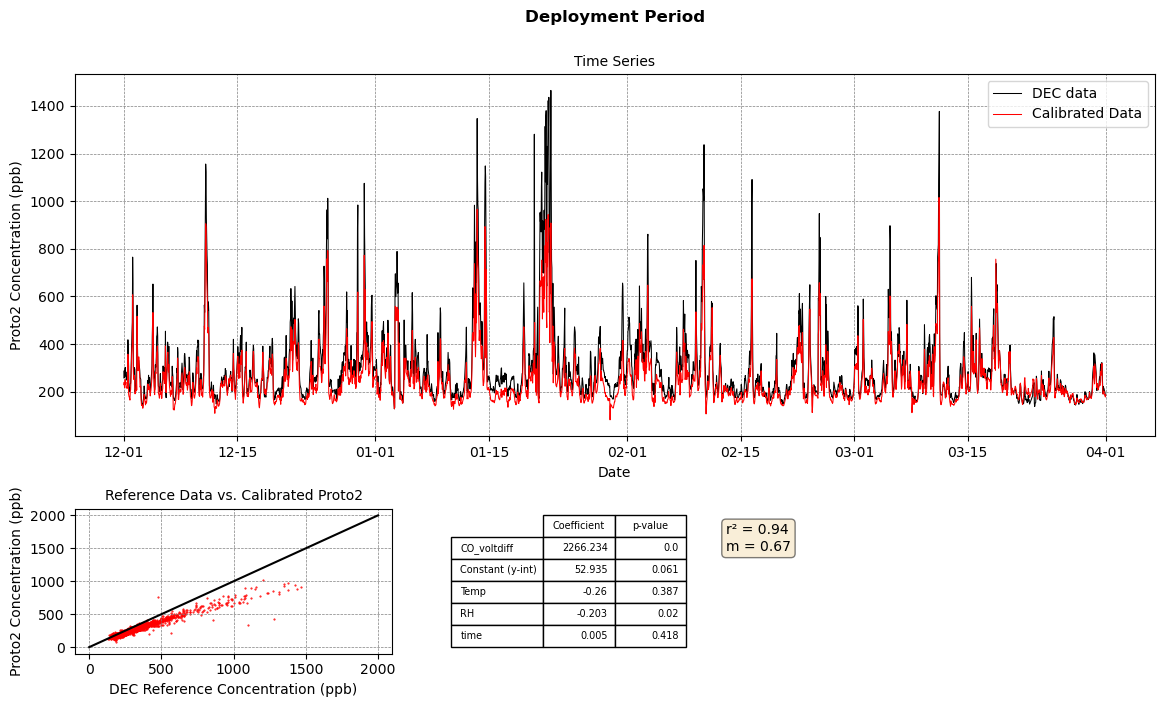

In [91]:
n=len(depl_ref_conc)
depl_r2 = (((n*(depl_calibrated_data*depl_ref_conc).sum())-(depl_calibrated_data.sum()*depl_ref_conc.sum()))\
        /np.sqrt((n*(depl_ref_conc**2).sum()-(depl_ref_conc).sum()**2)*\
                 (n*(depl_calibrated_data**2).sum()-depl_calibrated_data.sum()**2)))**2
print('Deployment period r-squared = ',depl_r2)

depl_slope = np.polyfit(depl_ref_conc,depl_calibrated_data,1)[0]
print('Deployment period slope = ',depl_slope)

depl_rmse = mean_squared_error(depl_ref_conc, depl_calibrated_data, squared=False)
print('Deployment period RMSE = ',depl_rmse)

norm_graph(var_id,depl_calibrated_data,simpleCOModel['coef_dict'], simpleCOModel['pvalue_dict'],
           depl_ref_conc, depl_ref_conc.index,'Deployment Period', linear_color='red')

Text(0.5, 1.0, 'Residuals vs. Fit')

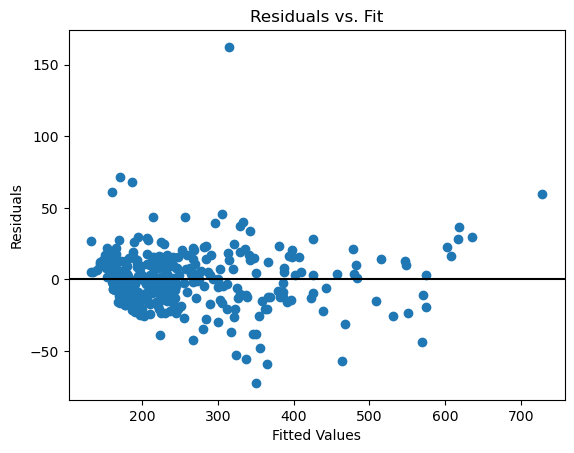

In [92]:
# access residuals 
residuals = simpleCOModel['model'].resid
fitted_values = training_calibrated_data

# create plot 
plt.figure()
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Residuals vs. Fit')

In [93]:
simpleCOModel['model'].aic

3071.908507307409

In [94]:
CO_Model['model'].aic

2919.8830626267572